## Imports

In [261]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import glob
import os
from dataclasses import dataclass, asdict
import cv2
import numpy as np
from matplotlib.colorbar import ColorbarBase


## Read data


In [69]:
@dataclass
class Exp_Sample:
    user_id: int
    age: int
    gender: str
    skill: int
    path: str
    ear_id: str
    ear_view_pos: int
    method: str
    first_img: bool = True
    total_time: int = 0
    sam1_proposed_am: int = 0
    sam2_proposed_am: int = 0
    sam1_interactive_am: int = 0
    sam2_interactive_am: int = 0
    polygon_drawing_am: int = 0
    sam2_tracking_am: int = 0
    panorama_tracking_am: int = 0
    total_masks_am: int = 0
    sam1_proposed_sm: int = 0
    sam2_proposed_sm: int = 0
    sam1_interactive_sm: int = 0
    sam2_interactive_sm: int = 0
    polygon_drawing_sm: int = 0
    sam2_tracking_sm: int = 0
    panorama_tracking_sm: int = 0
    total_masks_sm: int = 0

@dataclass
class Exp_Mask:
    user_id: int
    path: str
    ear_id: str
    ear_view_pos: int
    method: str
    first_img: bool 
    tool: str
    time_stamp: int 
    time_delta: int = 0

class SampleInfoPerUser:
    def __init__(self, path:str, user_id:int):
        self.user_dir = path
        self.dir_paths = glob.glob(path + "/*")
        self.user_id = user_id

    def __call__(self):
        img_dirs = [item for item in self.dir_paths if os.path.isdir(item)]
        self.exp_samples = [self.get_path_information(path, self.user_id) for path in img_dirs]
        self.exp_samples, self.samlpe_pairs = self.find_sample_pairs(self.exp_samples)
        self.exp_samples = [self.get_log_info(sample) for sample in self.exp_samples]
        return self.exp_samples

    def get_path_information(self, path:str, user_id:int):
        base_name = os.path.basename(path)
        splits = base_name.split('_')
        for i, sub_split in enumerate(splits):
            if 'low' in sub_split:
                ear_view_pos = splits[i+1]
                break
        ear_id = splits[0]
        if "polygon" in base_name:
            method = "polygon"
        elif "sam1" in base_name :
            method = "sam1"
        elif "sam2" in base_name:
            method = "sam2"
        age, gender, skills = self.get_user_info()
        exp_sample = Exp_Sample(user_id, age, gender, skills, path, ear_id, ear_view_pos, method)
        return exp_sample
    
    def get_user_info(self):
        with open (os.path.join(self.user_dir, "user_information.json")) as f:
            user_info = json.load(f)
        return user_info["age"], user_info["gender"], user_info["skills"]

    def find_sample_pairs(self, exp_samples: list[Exp_Sample]):
        sample_pairs = []
        sample_paths_done = []
        for exp_sample1 in exp_samples:
            for exp_sample2 in exp_samples:
                if exp_sample1.ear_id == exp_sample2.ear_id and exp_sample1.method == exp_sample2.method:
                    if not exp_sample1 == exp_sample2:
                        if not exp_sample1.path in sample_paths_done and not exp_sample2.path in sample_paths_done:
                            sample_paths_done.append(exp_sample1.path)
                            sample_paths_done.append(exp_sample2.path)
                            self.find_first_imgs(exp_sample1, exp_sample2)
                            sample_pairs.append((exp_sample1, exp_sample2))
        return exp_samples, sample_pairs

    def find_first_imgs(self, sample1, sample2):
        if sample1.ear_view_pos > sample2.ear_view_pos:
            sample1.first_img = True
            sample2.first_img = False
        elif sample1.ear_view_pos < sample2.ear_view_pos:
            sample1.first_img = False
            sample2.first_img = True

    def get_log_info(self, sample: Exp_Sample):
        log_p = sample.path + "/log.json"
        if not os.path.exists(log_p):
            raise FileNotFoundError(f"Log file not found in {log_p}")
        with open(log_p) as f:
            log = json.load(f)

        sample.total_time = log["Total_time"]
        sample.sam1_proposed_am = log["All_masks"]["Sam1_proposed"]
        sample.sam2_proposed_am = log["All_masks"]["Sam2_proposed"]
        sample.sam1_interactive_am = log["All_masks"]["Sam1_interactive"]
        sample.sam2_interactive_am = log["All_masks"]["Sam2_interactive"]
        sample.polygon_drawing_am = log["All_masks"]["Polygon_drawing"]
        sample.sam2_tracking_am = log["All_masks"]["Sam2_tracking"]
        sample.panorama_tracking_am = log["All_masks"]["Panorama_tracking"]
        sample.total_masks_am = log["All_masks"]["Total_masks"]
        sample.sam1_proposed_sm = log["Selected_masks"]["Sam1_proposed"]
        sample.sam2_proposed_sm = log["Selected_masks"]["Sam2_proposed"]
        sample.sam1_interactive_sm = log["Selected_masks"]["Sam1_interactive"]
        sample.sam2_interactive_sm = log["Selected_masks"]["Sam2_interactive"]
        sample.polygon_drawing_sm = log["Selected_masks"]["Polygon_drawing"]
        sample.sam2_tracking_sm = log["Selected_masks"]["Sam2_tracking"]
        sample.panorama_tracking_sm = log["Selected_masks"]["Panorama_tracking"]
        sample.total_masks_sm = log["Selected_masks"]["Total_masks"]
        return sample
    
class MaskInfoPerUser:
    def __init__(self, samples: list[Exp_Sample]):
        self.samples = samples
        self.prev_ts = 0
        self.exp_masks = []

    def __call__(self):

        for sample in self.samples:
            sample_p = sample.path
            mask_dirs = glob.glob(sample_p + "/masks/*")
            exp_masks = [self.read_mask_name(mask_path, sample) for mask_path in mask_dirs]
            exp_masks = sorted(exp_masks, key=lambda x: int(x.time_stamp))
            exp_masks = [self.get_time_delta(mask) for mask in exp_masks]
            
            
            self.exp_masks.extend(exp_masks)
        
                
            self.prev_ts = 0  
        return self.exp_masks

    def read_mask_name(self, mask_path:str, sample:Exp_Sample):
        mask_name = os.path.basename(mask_path)
        name_splits = mask_name.split('_')
        time_stamp = name_splits[2]
        tool = name_splits[1]
        exp_mask = Exp_Mask(sample.user_id, mask_path, sample.ear_id, sample.ear_view_pos, sample.method, sample.first_img, tool, time_stamp)
        return exp_mask

    def get_time_delta(self, exp_mask: Exp_Mask):
        if exp_mask.method == "polygon":
            exp_mask.time_delta = int(exp_mask.time_stamp)

        else:
            exp_mask.time_delta = int(exp_mask.time_stamp) - self.prev_ts
            self.prev_ts = int(exp_mask.time_stamp)
        return exp_mask
    
def get_df_tool(df_sample: pd.DataFrame):
    ds_keys = ["ds_per_mask_track", "ds_per_mask_amg", "ds_per_mask_inter", "ds_per_mask_poly"]
    n_keys = ["track_n", "amg_n", "inter_n", "poly_n"]
    all_keys = ds_keys + n_keys
    untouched_cols = [col for col in df_sample.columns if col not in all_keys]
    df_tool0 = df_sample.melt(
        id_vars=[col for col in df_sample.columns if col not in ds_keys],
        value_vars=ds_keys,
        var_name="tool",
        value_name="ds_per_mask_tool"
)
    df_tool0["tool"] = df_tool0["tool"].str.split("_").str[-1]
    df_tool0.drop(columns=n_keys, inplace=True)

    df_tool1 = df_sample.melt(
        id_vars=[col for col in df_sample.columns if col not in n_keys],
        value_vars=n_keys,
        var_name="tool",
        value_name="n_per_tool"
)
    df_tool1["tool"] = df_tool1["tool"].str.split("_").str[0]
    df_tool1.drop(columns=ds_keys, inplace=True)

    df_tool = pd.merge(df_tool0, df_tool1, on=["tool", *untouched_cols])
    return df_tool




In [39]:
def _check_tool_presence(df:pd.DataFrame, tools_unique, tools_to_skip:list[str], total_time:int, ts_offset:int=0):
    '''
    Tool time calculation: 
        Tracked masks time = ts of the first mask of next method (or total time if no more methods)
        AMG masks time = ts of the last mask of the same method - Tracked masks time
        Interactive masks time = ts of the last mask of the same method - AMG masks time
        Polygon masks time = ts of the last mask of the same method - Interactive masks time
 
    '''


    timed_tool = tools_to_skip[0]
    remaining_tools = list(set(tools_unique) - set(tools_to_skip))

    if timed_tool in tools_unique and len(df.loc[df["tool"]==timed_tool]) > 1:
        if len(remaining_tools) > 0:
            if timed_tool in["pat", "s2t"]:
                track_time = int(df.loc[~df["tool"].isin(tools_to_skip), "time_stamp"].min())-ts_offset
            else:
                track_time = int(df.loc[df["tool"]==timed_tool, "time_stamp"].max())-ts_offset
            
        elif len(remaining_tools) == 0:
            track_time = total_time - ts_offset
    else:
        track_time = None

    return track_time, tools_to_skip
    
def _calc_tool_time(df: pd.DataFrame,total_time:int):
    track_time, amg_time, inter_time, poly_time = None, None, None, None
    ts_offset = 0
    if df["method"].unique()[0] == "polygon":
        return track_time, amg_time, inter_time, poly_time
    elif len (df["method"].unique()) > 1:
        raise ValueError("More than one method in the dataframe")
     
    #exlcude rows referring to the first occurance of min time_stamp value per tool
    df = df.astype({"time_stamp":int})
    df = df.iloc[~df.index.isin(df.groupby("tool")["time_stamp"].idxmin().values)]
    tools = df["tool"].unique()
    
    

    track_time, tools_to_skip = _check_tool_presence(df, tools, ["pat"], total_time, ts_offset)
    if track_time is None:
        track_time, tools_to_skip = _check_tool_presence(df, tools, ["s2t", *tools_to_skip], total_time, ts_offset)
    if track_time is not None: ts_offset += track_time

    amg_time, tools_to_skip = _check_tool_presence(df, tools, ["s1p", *tools_to_skip], total_time, ts_offset)
    if amg_time is None:
        amg_time, tools_to_skip = _check_tool_presence(df, tools, ["s2p", *tools_to_skip], total_time, ts_offset)
    if amg_time is not None: ts_offset += amg_time
    
    inter_time, tools_to_skip = _check_tool_presence(df, tools, ["s1i", *tools_to_skip], total_time, ts_offset)
    if inter_time is None:
        inter_time, tools_to_skip = _check_tool_presence(df, tools, ["s2i", *tools_to_skip], total_time, ts_offset)
    if inter_time is not None: ts_offset += inter_time

    poly_time, tools_to_skip = _check_tool_presence(df, tools, ["plg", *tools_to_skip], total_time, ts_offset)

    return track_time, amg_time, inter_time, poly_time
    

def get_time_per_tool(df_sample:pd.DataFrame, df_mask:pd.DataFrame):
    df_mask = df_mask.copy()
    df_mask["ear_img"] = df_mask.loc[:, "ear_id"] + "_" + df_mask.loc[:, "ear_view_pos"]
    df_mask["method_imgpos"] = df_mask.loc[:, "method"] +  "_" + df_mask.loc[:, "first_img"].astype(str).str.replace("True", "1")
    df_mask["method_imgpos"] = df_mask.loc[:, "method_imgpos"].str.replace("False","2")
    df_mask["method_imgpos_ear"] = df_mask.loc[:, "method_imgpos"] + "_" + df_mask.loc[:, "ear_id"]
    user_ids = df_sample["user_id"].unique()

    for user_id in user_ids:
        df_user_masks = df_mask.loc[df_mask["user_id"] == user_id]
        ear_samples = df_user_masks["method_imgpos_ear"].unique()
        for sample in ear_samples:
            df_ear = df_user_masks.loc[df_user_masks["method_imgpos_ear"] == sample]
            track_time, amg_time, inter_time, poly_time = _calc_tool_time(df_ear,df_sample.loc[(df_sample["user_id"] == user_id)&(df_sample["method_imgpos_ear"]==sample), "total_time"].values[0])
            df_sample.loc[(df_sample["user_id"] == user_id)&(df_sample["method_imgpos_ear"]==sample), "track_time"] = track_time
            df_sample.loc[(df_sample["user_id"] == user_id)&(df_sample["method_imgpos_ear"]==sample), "amg_time"] = amg_time
            df_sample.loc[(df_sample["user_id"] == user_id)&(df_sample["method_imgpos_ear"]==sample), "inter_time"] = inter_time
            df_sample.loc[(df_sample["user_id"] == user_id)&(df_sample["method_imgpos_ear"]==sample), "poly_time"] = poly_time

    return df_sample
def unite_maskn_cols(df:pd.DataFrame):
    df["track_n"] = df.loc[:,"sam2_tracking_sm"] + df.loc[:,"panorama_tracking_sm"]
    df["amg_n"] = df.loc[:,"sam1_proposed_sm"] + df.loc[:,"sam2_proposed_sm"]
    df["inter_n"] = df.loc[:,"sam1_interactive_sm"] + df.loc[:,"sam2_interactive_sm"]
    df.rename(columns={"polygon_drawing_sm":"poly_n"}, inplace=True)
    df = df.astype({"track_n":int, "amg_n":int, "inter_n":int, "poly_n":int})
    return df

def get_time_per_tool_and_mask(df:pd.DataFrame, mask_n_key:str, time_key:str):
    ds_mask_series = df.apply(
        lambda row: row[time_key] / row[mask_n_key] if pd.notnull(row[time_key]) and pd.notnull(row[mask_n_key]) else None,
        axis=1
    )
    return ds_mask_series.astype(np.float32)
    

In [70]:
exp_result_dirs = glob.glob(r"C:\Users\geink81\Desktop\ARAMSAM_UserExperiment/*")
samples_list = []
mask_info_list = []

for user_result_dir in exp_result_dirs:
    user_id = os.path.basename(user_result_dir).split("_")[-1]
    samples = SampleInfoPerUser(user_result_dir, user_id)
    sample_info = samples()
    masks = MaskInfoPerUser(sample_info)
    samples_list.extend(sample_info)
    mask_info_list.extend(masks())

df_sample = pd.DataFrame([asdict(sample) for sample in samples_list])
df_mask = pd.DataFrame([asdict(mask) for mask in mask_info_list])

INVALID_USERS = ["2", "3", "11", "7"]
df_sample = df_sample.loc[~df_sample["user_id"].isin(INVALID_USERS)]
df_mask = df_mask.loc[~df_mask["user_id"].isin(INVALID_USERS)]

df_sample = unite_maskn_cols(df_sample)
df_sample["ds_per_mask"] = df_sample.loc[:, "total_time"] / df_sample.loc[:, "total_masks_sm"]
df_sample["user_img"] = df_sample.loc[:, "user_id"].astype(str) + "_" + df_sample.loc[:, "ear_id"] 
df_sample["method_imgpos"] = df_sample.loc[:, "method"] +  "_" + df_sample.loc[:, "first_img"].astype(str).str.replace("True", "1")
df_sample["method_imgpos"] = df_sample.loc[:, "method_imgpos"].str.replace("False","2")
df_sample["method_imgpos_ear"] = df_sample.loc[:, "method_imgpos"] + "_" + df_sample.loc[:, "ear_id"]
df_sample["ear_img"] = df_sample.loc[:, "ear_id"] + "_" + df_sample.loc[:, "ear_view_pos"]

df_sample = get_time_per_tool(df_sample, df_mask)
df_sample["ds_per_mask_track"] =  get_time_per_tool_and_mask(df_sample, "track_n", "track_time")
df_sample["ds_per_mask_amg"] =  get_time_per_tool_and_mask(df_sample, "amg_n", "amg_time")
df_sample["ds_per_mask_inter"] =  get_time_per_tool_and_mask(df_sample, "inter_n", "inter_time")
df_sample["ds_per_mask_poly"] =  get_time_per_tool_and_mask(df_sample, "poly_n", "poly_time")

df_tool = get_df_tool(df_sample)
print(df_tool.head())

#print(df_sample["ear_img"].value_counts())


#print(df_mask.describe())

#df_mask.to_csv("test.csv", index = False)
df_sample.to_csv("UserExperimentResults.csv", index=False)




  user_id  age gender  skill  \
0       0   26   Male      7   
1       0   26   Male      7   
2       0   26   Male      7   
3       0   26   Male      7   
4       0   26   Male      7   

                                                path          ear_id  \
0  C:\Users\geink81\Desktop\ARAMSAM_UserExperimen...  39320223493024   
1  C:\Users\geink81\Desktop\ARAMSAM_UserExperimen...  39320223493024   
2  C:\Users\geink81\Desktop\ARAMSAM_UserExperimen...  39320223493024   
3  C:\Users\geink81\Desktop\ARAMSAM_UserExperimen...  39320223493024   
4  C:\Users\geink81\Desktop\ARAMSAM_UserExperimen...  39320223493024   

  ear_view_pos   method  first_img  total_time  ...  method_imgpos  \
0          192     sam1      False        3362  ...         sam1_2   
1          192     sam2      False         748  ...         sam2_2   
2          256     sam1       True        3609  ...         sam1_1   
3          256     sam2       True        3562  ...         sam2_1   
4          256  polygon 

## Statistics

### Plotting

In [82]:
def get_violin_plot(df, xkey, ykey, colour_key):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200)
    sns.violinplot(data=df, x=xkey, y=ykey, hue=colour_key) # Smart agricultural technology color "#2fb2b2"
    

def get_box_plot(df, xkey, ykey, colour_key=None, ax=None, cmap_idx=None):
    custom_cmap = sns.color_palette(['#aa4499','#44aa99'])
    if cmap_idx is not None:
        custom_cmap = sns.color_palette(['#aa4499','#44aa99'][cmap_idx])
    if ax is None:
        plt.rcParams["font.family"] = "Times New Roman"
        plt.figure(dpi=200)
    ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
    return ax

def get_swarm_plot(df, xkey, ykey, colour_key, fs = None):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure(dpi=200, figsize=fs)
    sns.swarmplot(data=df, x=xkey, y=ykey, hue=colour_key)
    if fs is not None:
        plt.xticks(rotation=45)

## Plot overview (Kruscht)

Mean time per mask over all images and users
Polygon
96.66666666666666
Sam1
27.535028286185625
Sam2
20.83913959592534
-------------------



C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 59.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 31.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to de

All methods, first img, Mean per img, Box Plot
All methods, first img, Mean per img, Swarm Plot


C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)


All methods, second img, Mean per img, Swarm Plot
Number of masks per User against image x method


c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


ds_per_mask per User against image x method
All methods, first img, All  masks, Box Plot
First Image
Second Image


C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Te

SAM1 - First vs second image
SAM2 - First vs second image
SAM1 first image vs. SAM2 second image


C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=custom_cmap)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\2175913024.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=xkey, y=ykey, hue=colour_key, ax=ax

    user_id          ear_id method  ds_per_mask  sam2_tracking_sm  \
1         0  39320223493024   sam2     8.500000                84   
16        1  39320223493024   sam2     0.011111                90   
21        1  39320223525022   sam2     0.014706                68   
46       12  39320223493024   sam2     4.847826                86   
61       13  39320223493024   sam2     2.818182                84   
66       13  39320223525022   sam2     3.545455                64   
71       13  39420224413028   sam2     0.008547               117   
91       15  39320223493024   sam2     7.133333                84   
121      17  39320223493024   sam2     6.863158                83   
126      17  39320223525022   sam2     8.676056                63   
131      17  39420224413028   sam2     6.474576               116   
151       5  39320223493024   sam2     7.082474                94   
221       9  39420224413028   sam2     0.008475               118   

     sam2_tracking_am  sam2_propo

c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 69.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 40.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 59.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\geink81\Desktop\pythonstuff\SequenceSAM-Annotator\ssavenv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of 

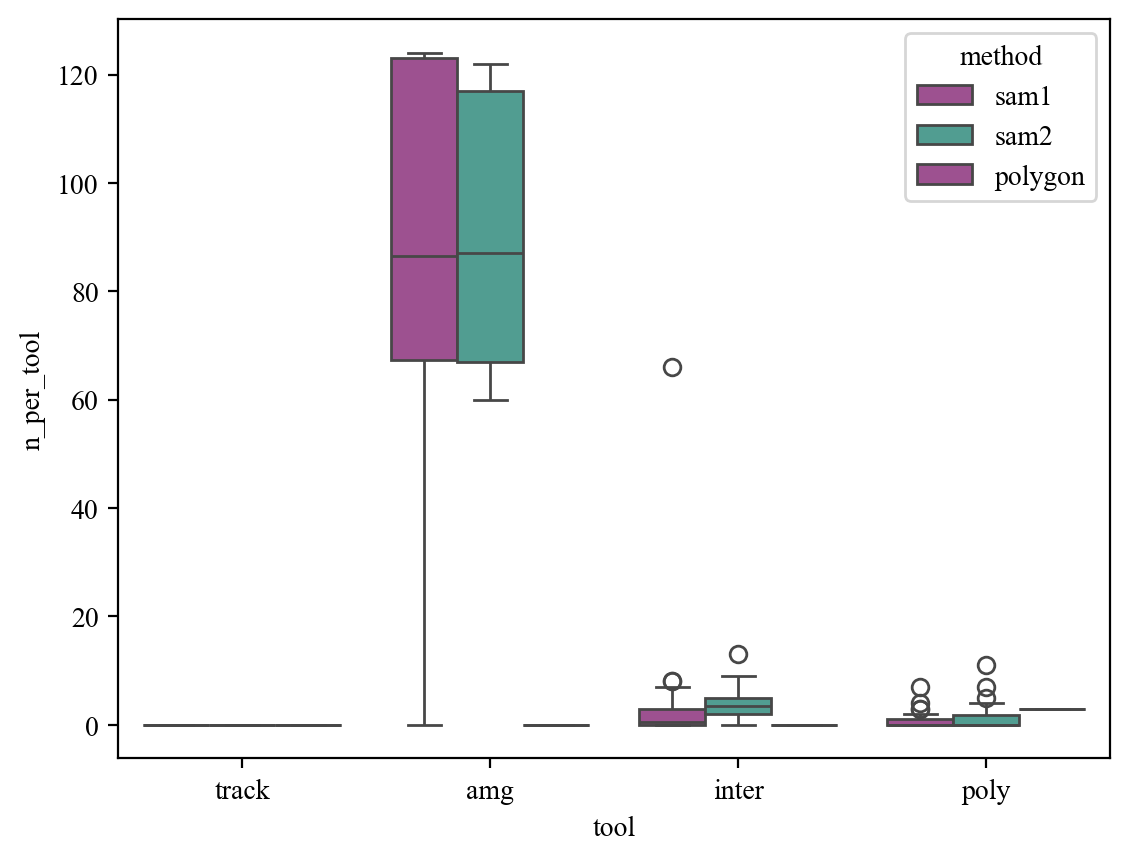

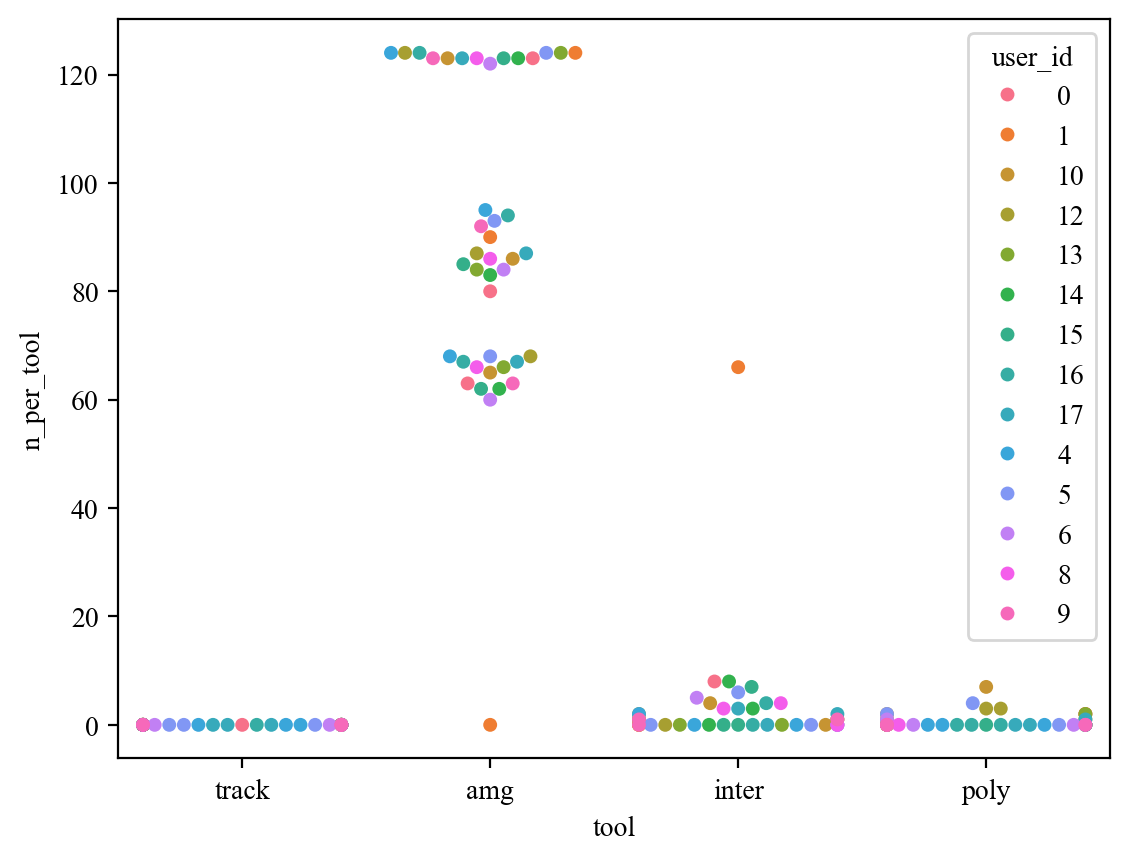

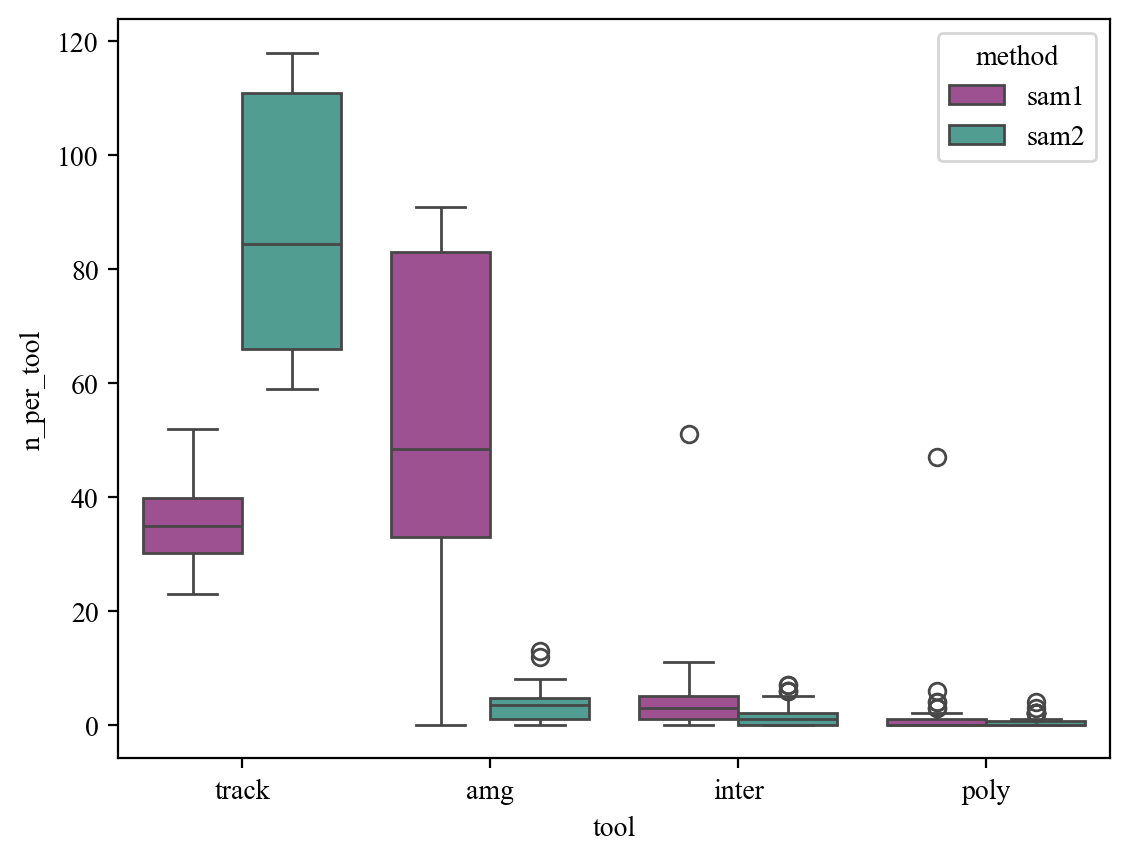

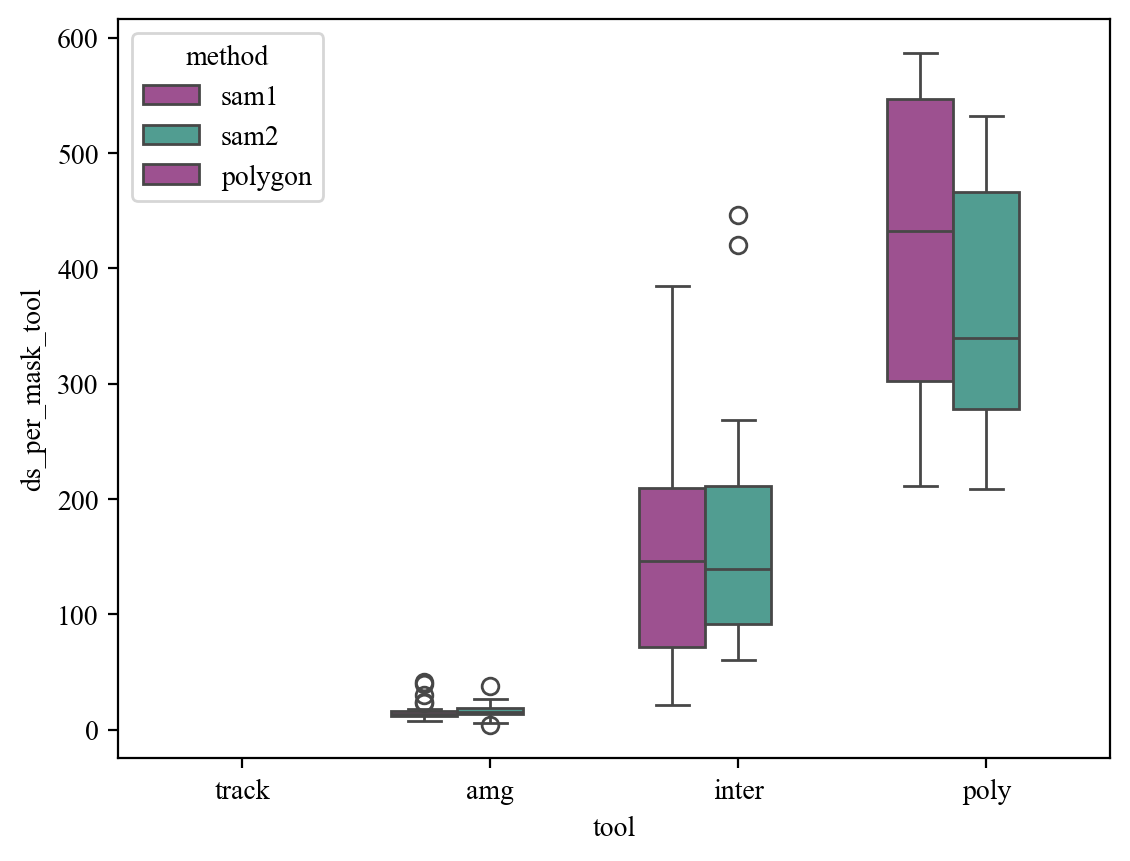

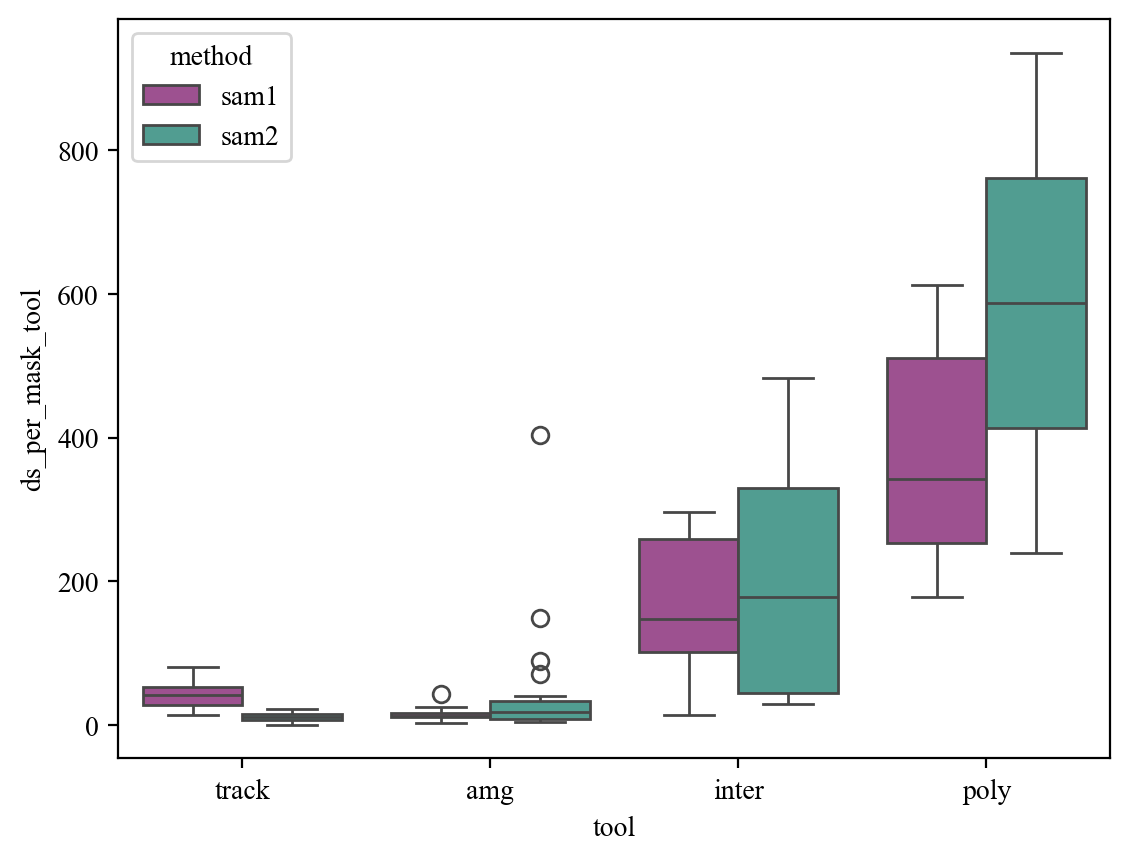

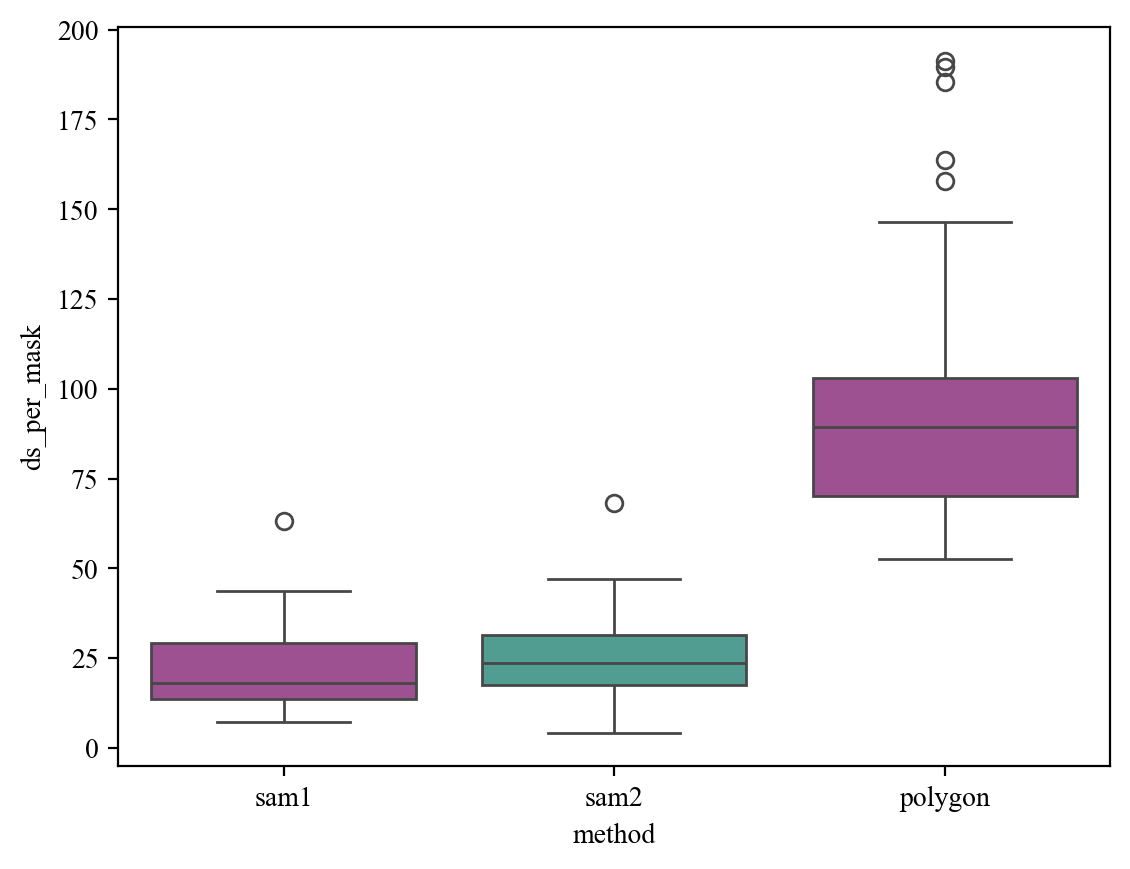

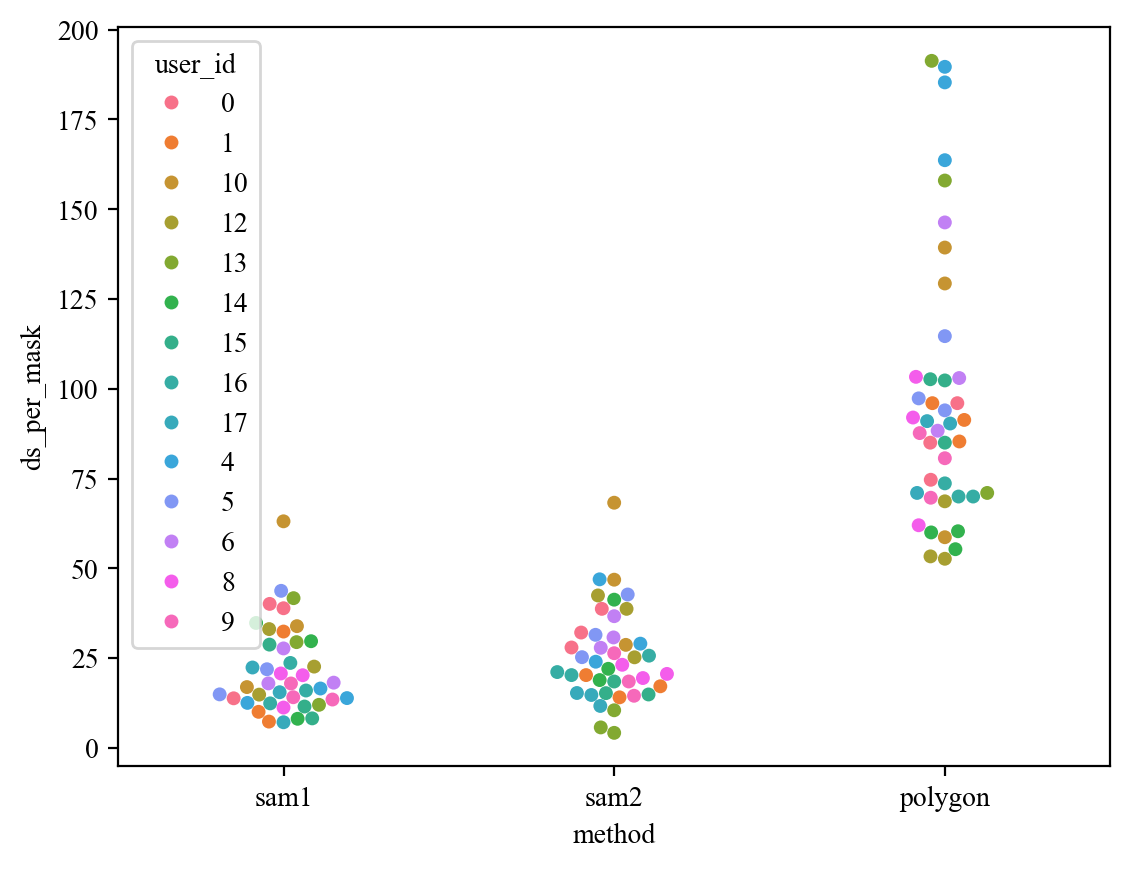

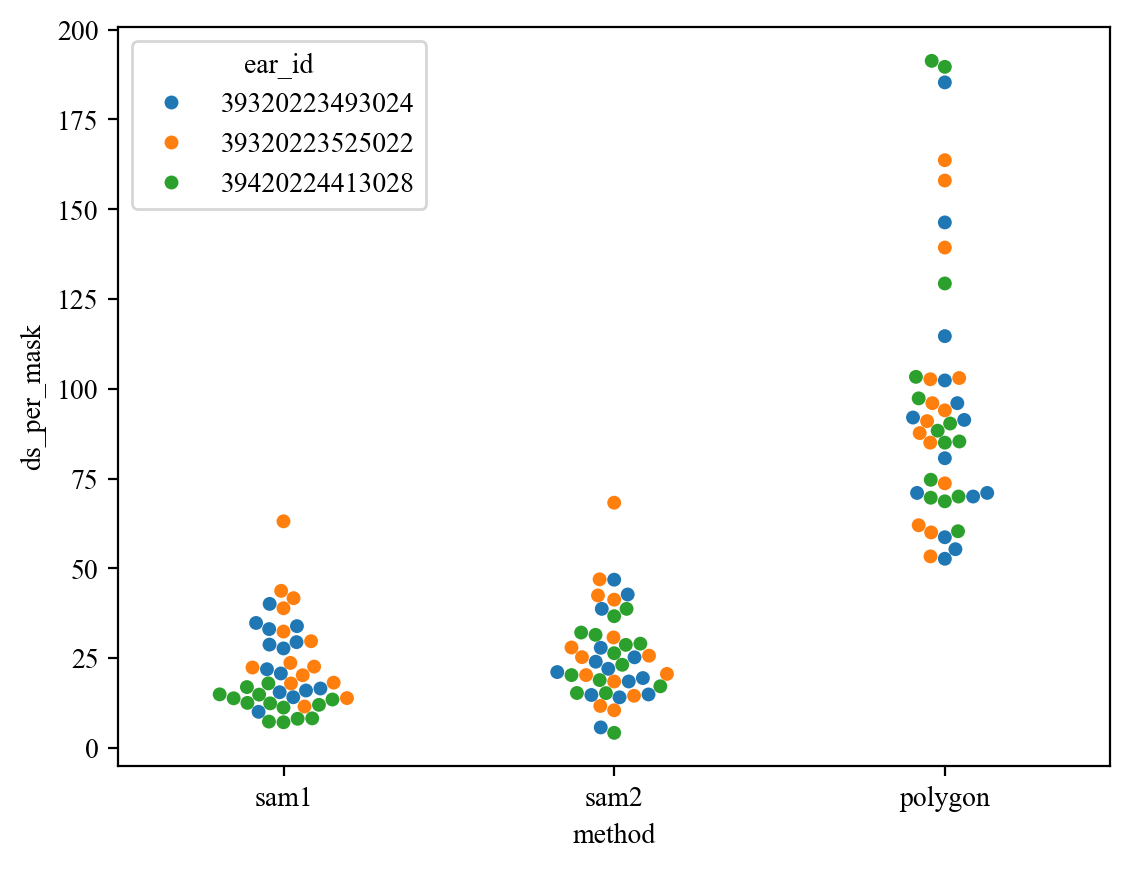

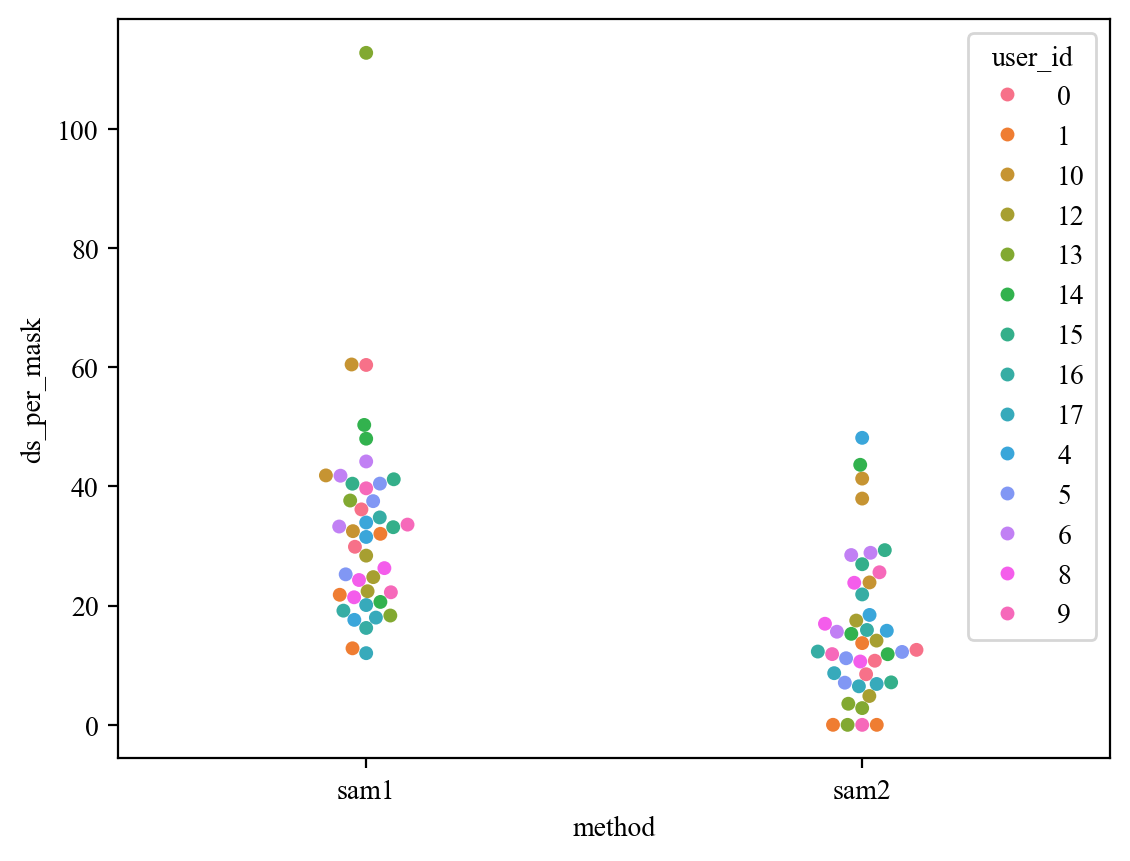

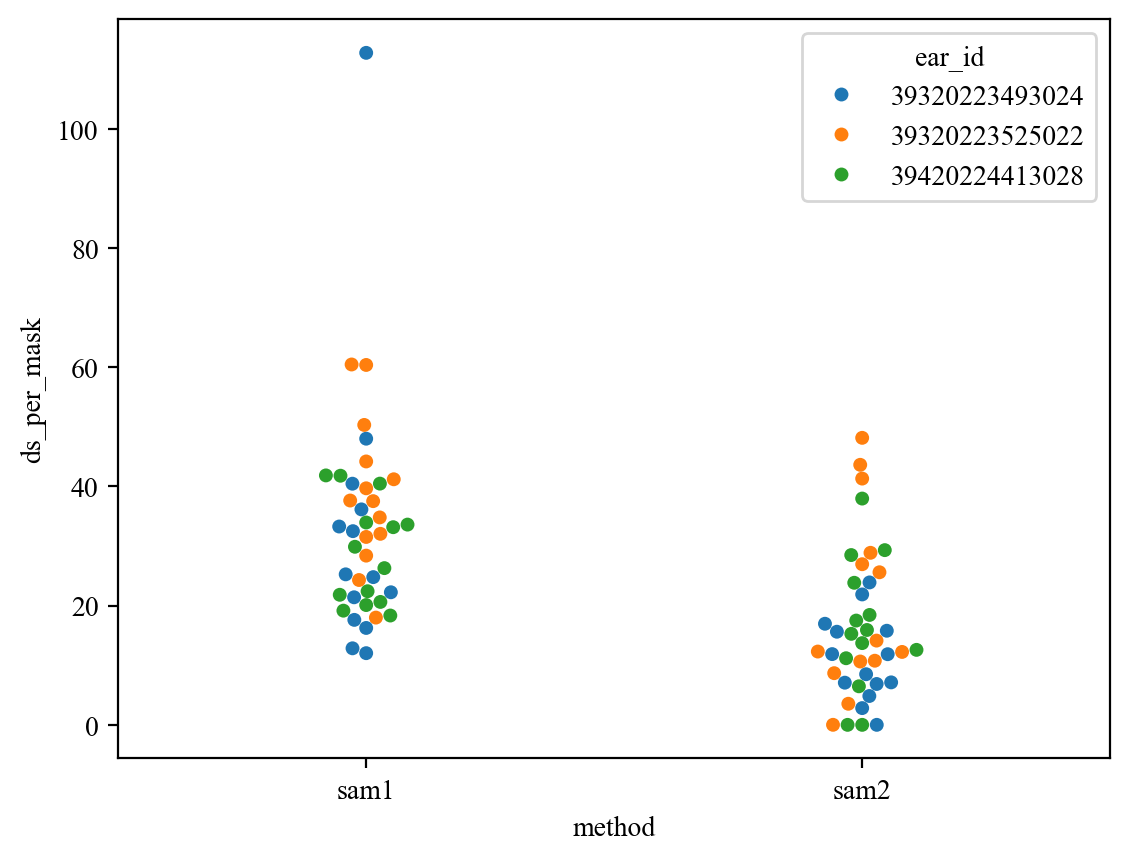

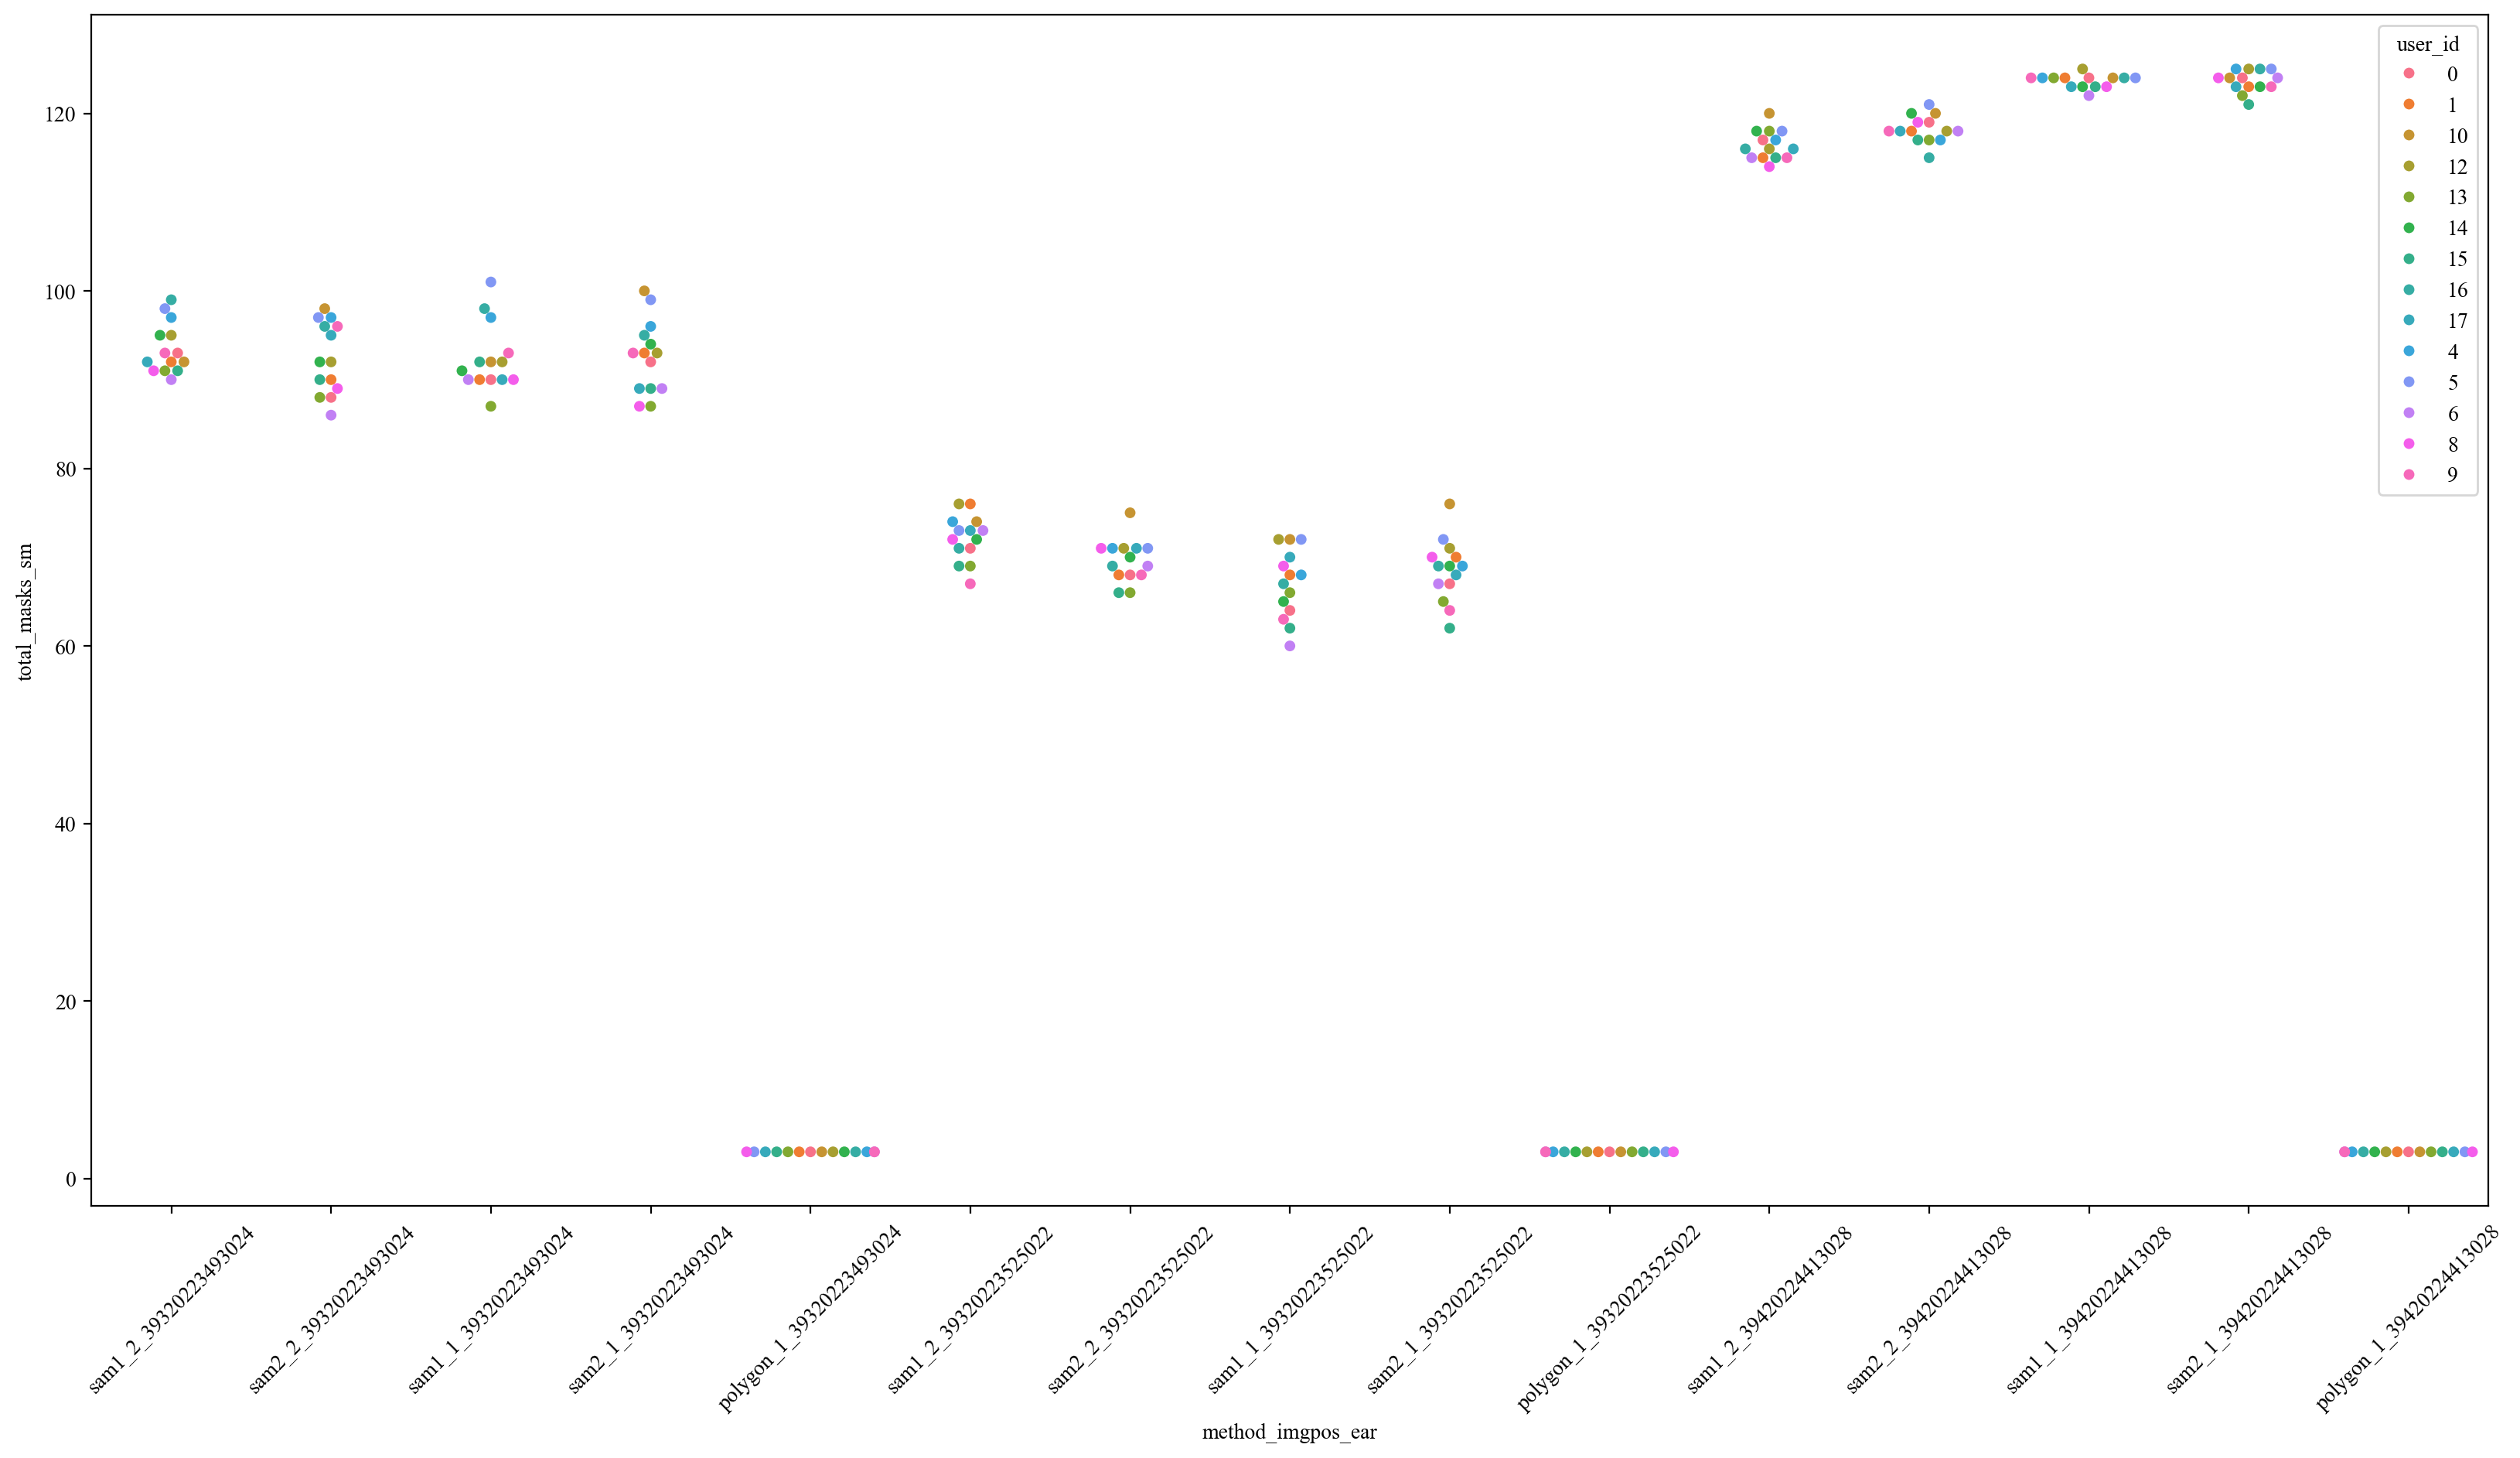

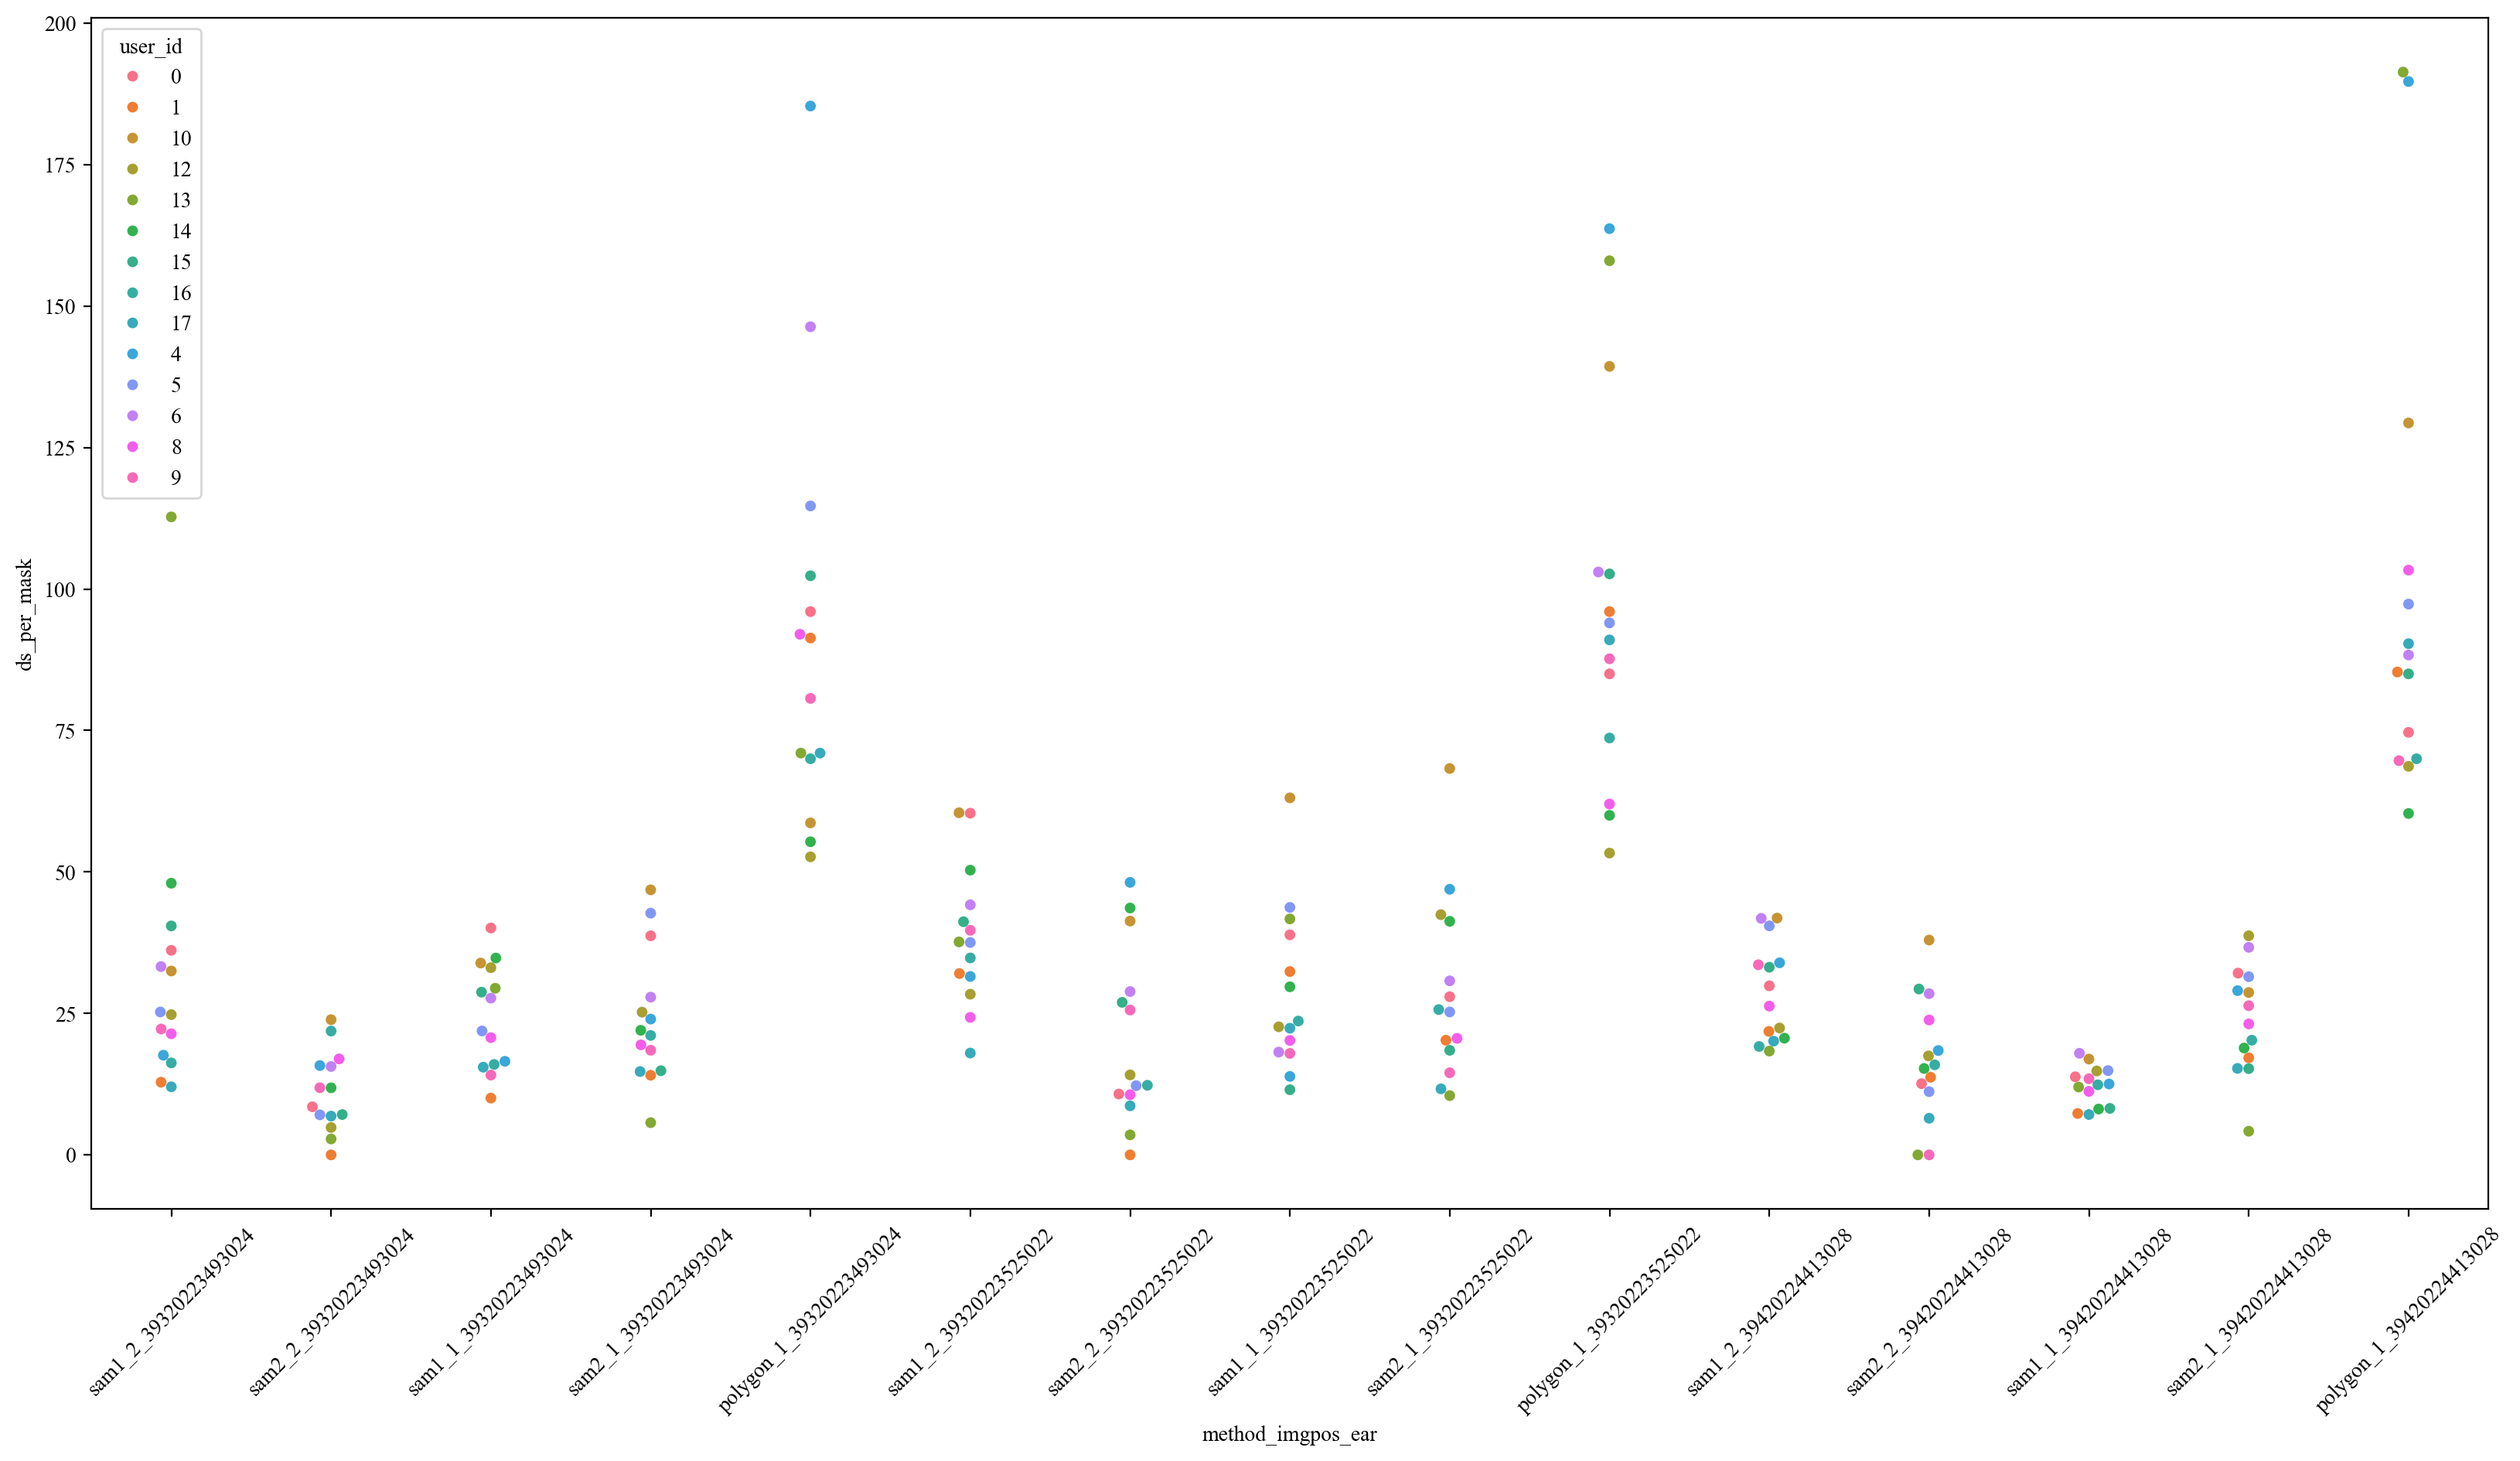

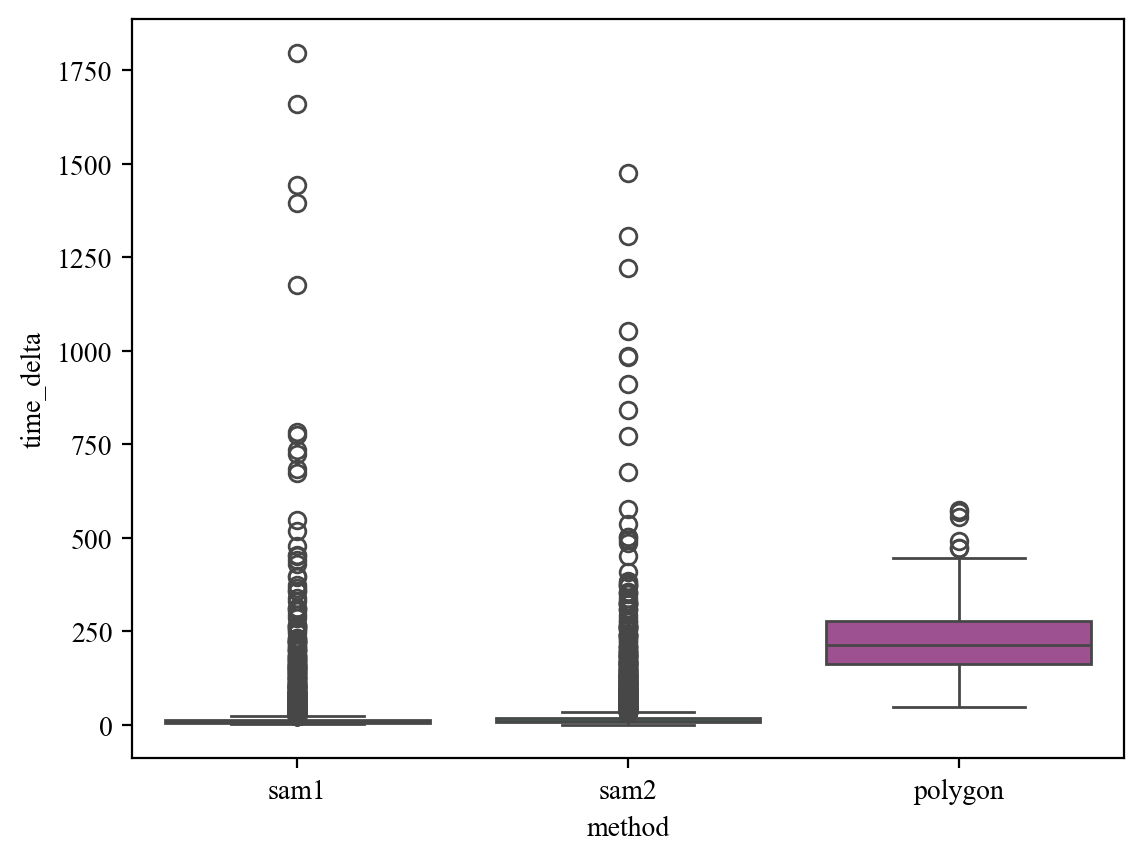

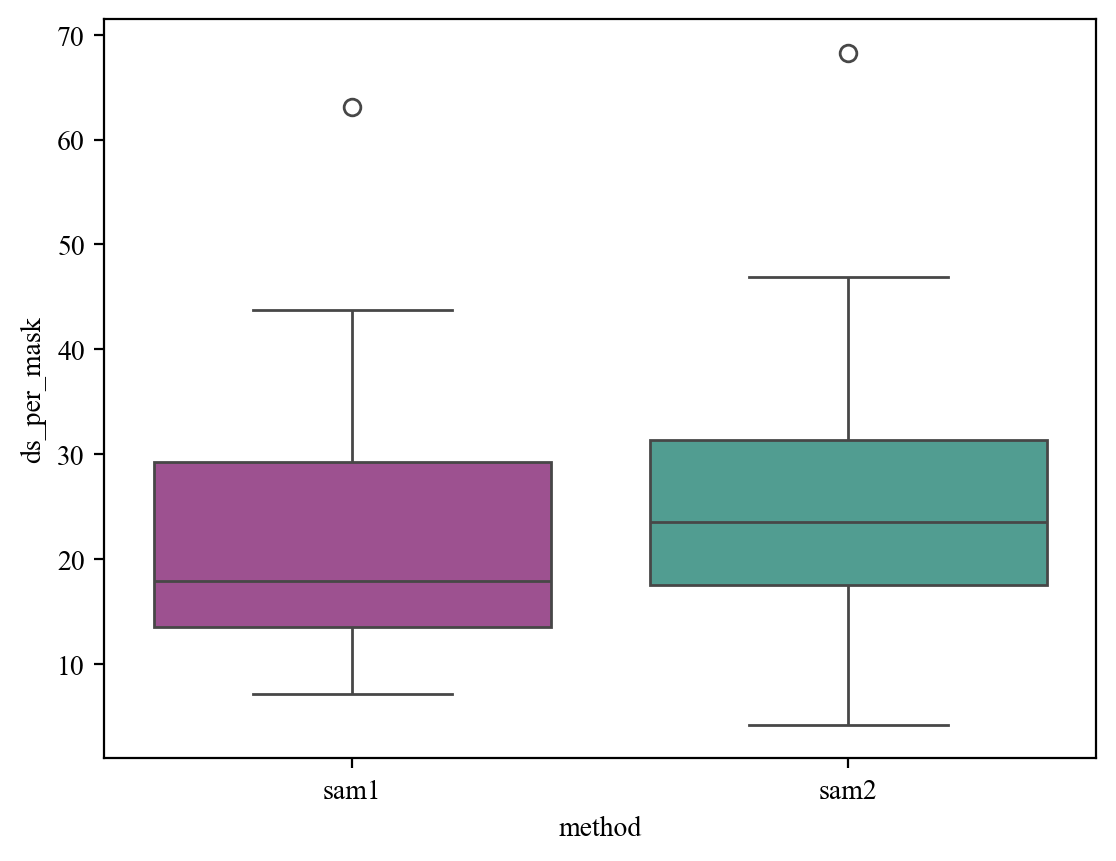

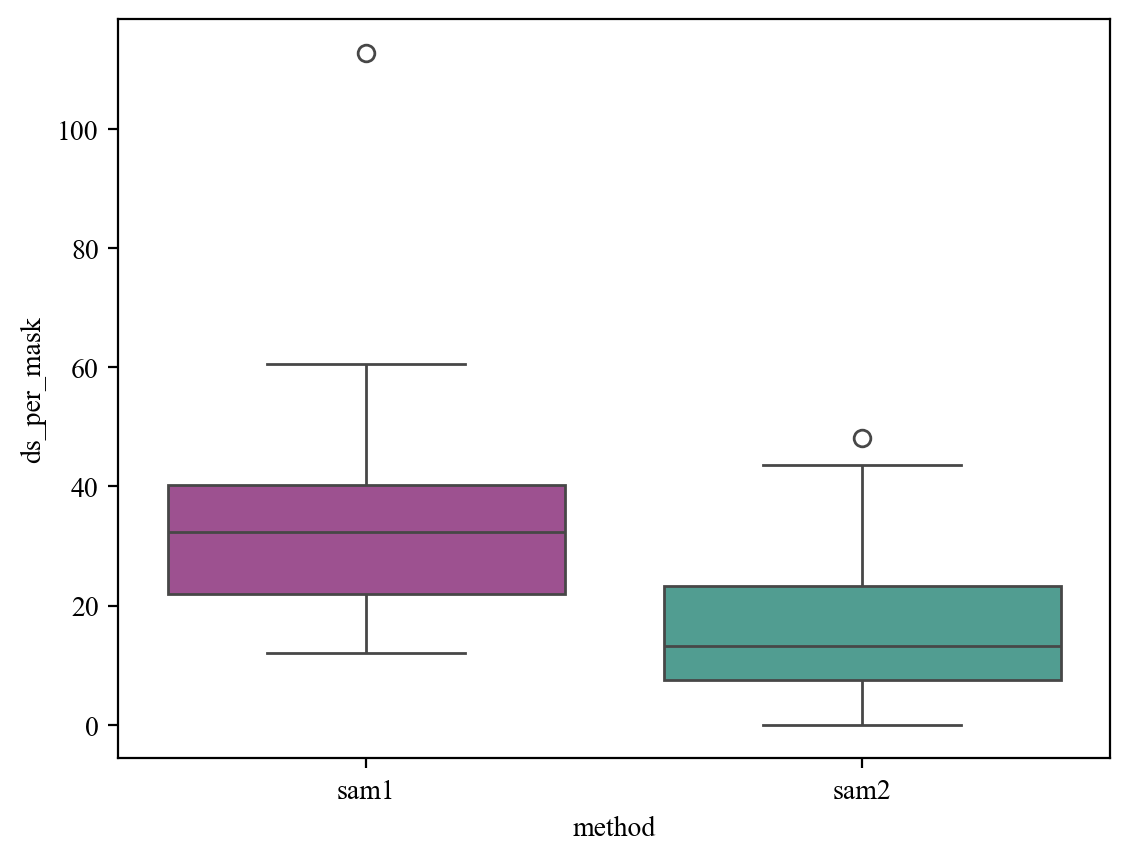

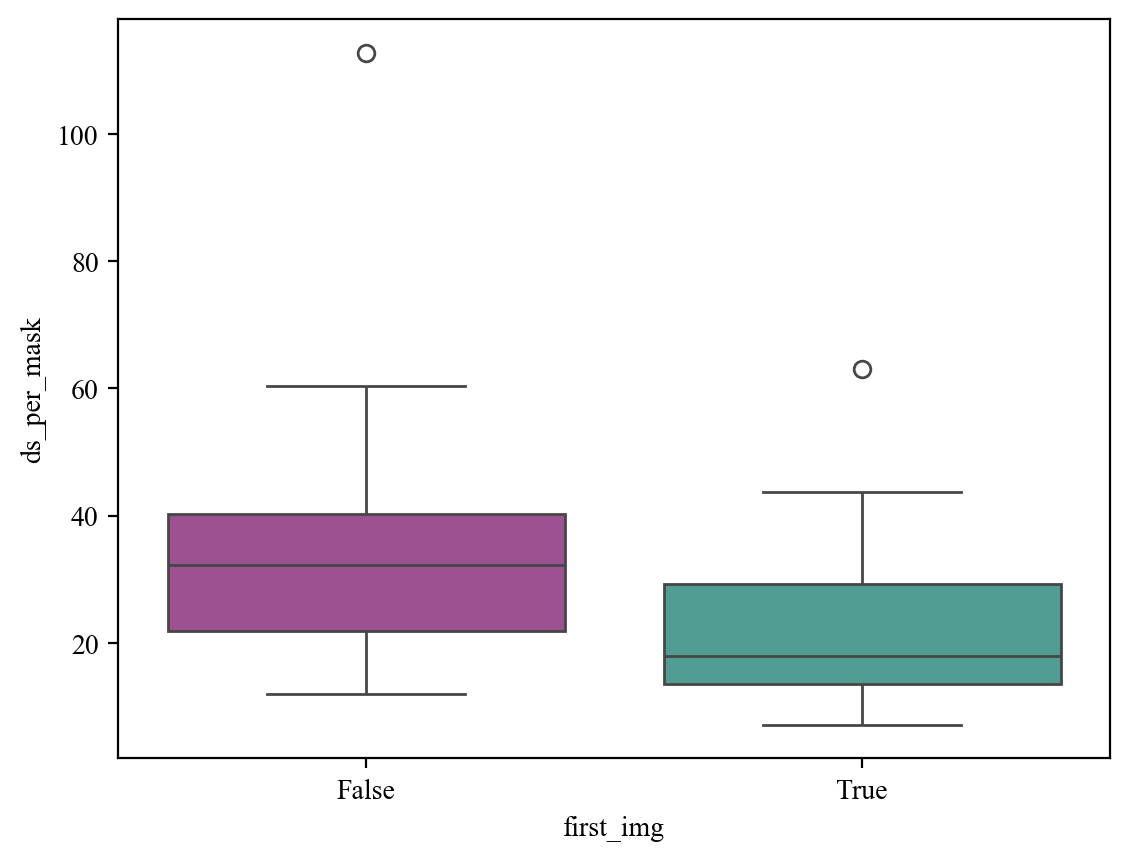

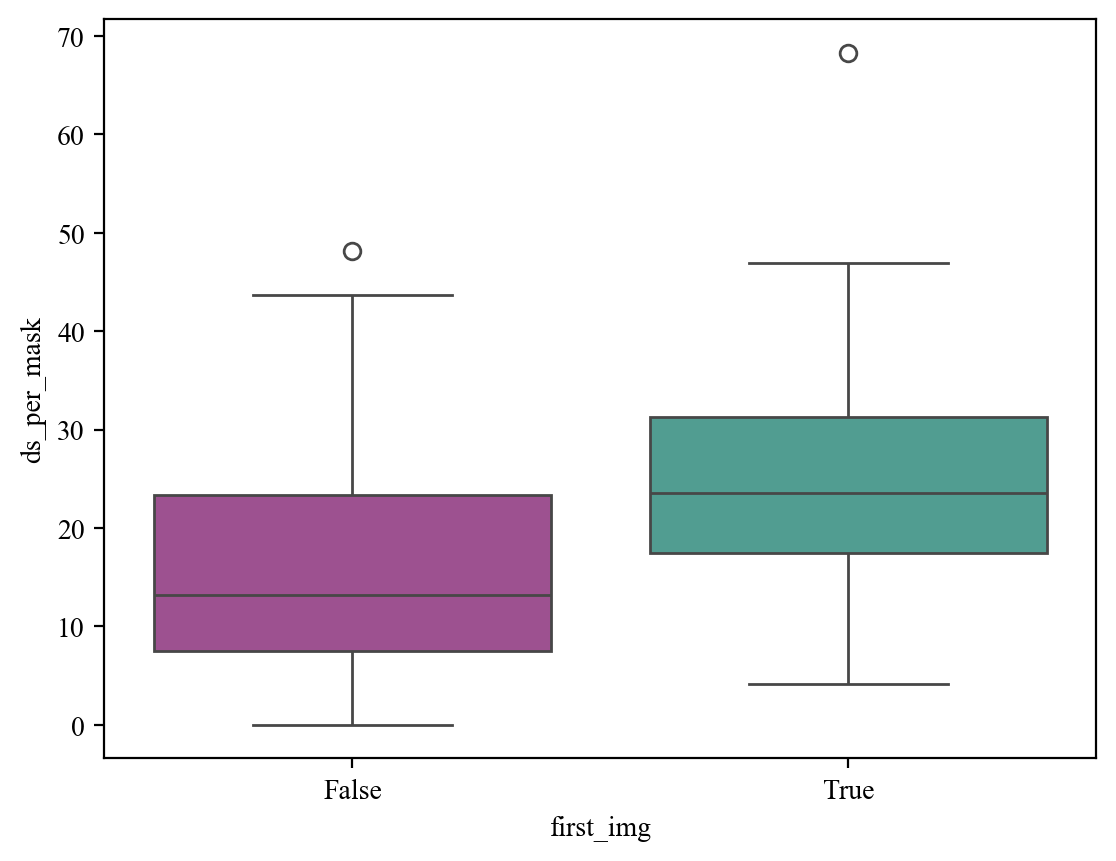

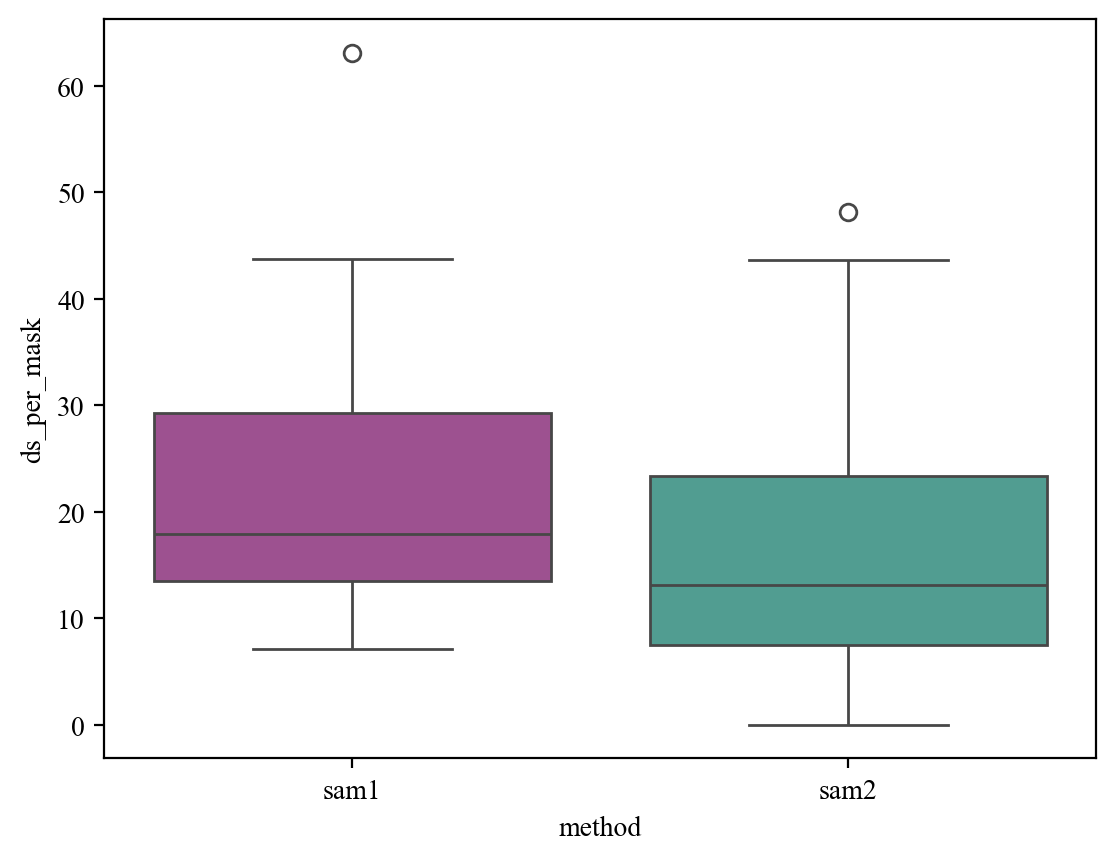

In [83]:
print("Mean time per mask over all images and users")
print("Polygon")
print((df_sample.loc[df_sample["method"]=='polygon', "total_time"] / df_sample.loc[df_sample["method"]=='polygon', "total_masks_sm"]).mean())
print("Sam1")
print((df_sample.loc[df_sample["method"]=='sam1', "total_time"] / df_sample.loc[df_sample["method"]=='sam1', "total_masks_sm"]).mean())
print("Sam2")
print((df_sample.loc[df_sample["method"]=='sam2', "total_time"] / df_sample.loc[df_sample["method"]=='sam2', "total_masks_sm"]).mean())
print("-------------------")
print()



get_box_plot(df_tool[df_tool["first_img"] == True], xkey="tool", ykey="n_per_tool", colour_key="method")
get_swarm_plot(df_tool.loc[(df_tool["first_img"] == True ) & (df_tool["method"]=="sam1") ], xkey="tool", ykey="n_per_tool", colour_key="user_id")
get_box_plot(df_tool[df_tool["first_img"] == False], xkey="tool", ykey="n_per_tool", colour_key="method")

get_box_plot(df_tool[df_tool["first_img"] == True], xkey="tool", ykey="ds_per_mask_tool", colour_key="method")
get_box_plot(df_tool[df_tool["first_img"] == False], xkey="tool", ykey="ds_per_mask_tool", colour_key="method")




print("All methods, first img, Mean per img, Box Plot")
get_box_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key=None)
print("All methods, first img, Mean per img, Swarm Plot")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == True ], xkey="method", ykey="ds_per_mask", colour_key="user_id")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == True], xkey="method", ykey="ds_per_mask", colour_key="ear_id")
print("All methods, second img, Mean per img, Swarm Plot")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == False ], xkey="method", ykey="ds_per_mask", colour_key="user_id")
get_swarm_plot(df_sample.loc[df_sample["first_img"] == False], xkey="method", ykey="ds_per_mask", colour_key="ear_id")


print("Number of masks per User against image x method")
get_swarm_plot(df_sample, xkey="method_imgpos_ear", ykey="total_masks_sm", colour_key="user_id", fs=(20, 10))
print("ds_per_mask per User against image x method")
get_swarm_plot(df_sample, xkey="method_imgpos_ear", ykey="ds_per_mask", colour_key="user_id", fs=(20, 10))


print("All methods, first img, All  masks, Box Plot")
get_box_plot(df_mask.loc[df_mask["first_img"] == True], xkey="method", ykey="time_delta", colour_key=None)

print('First Image')
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == True)], xkey="method", ykey="ds_per_mask", colour_key=None)
print('Second Image')
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == False)], xkey="method", ykey="ds_per_mask", colour_key=None)
print("SAM1 - First vs second image")
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam1")], xkey="first_img", ykey="ds_per_mask", colour_key=None)
print("SAM2 - First vs second image")
get_box_plot(df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam2")], xkey="first_img", ykey="ds_per_mask", colour_key=None)

print("SAM1 first image vs. SAM2 second image")
df_sam1f = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam1") & (df_sample["first_img"] == True)]
df_sam2s = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["method"] == "sam2") & (df_sample["first_img"] == False)]
df_sam1f_sam2s = pd.concat([df_sam1f, df_sam2s])
get_box_plot(df_sam1f_sam2s, xkey="method", ykey="ds_per_mask", colour_key=None)

# check whethter users added maks in the second image at all
df_temp = df_sample.loc[(df_sample['method'] != 'polygon') & (df_sample["first_img"] == False)]
print(df_temp.loc[df_temp['ds_per_mask'] < 10., ['user_id', 'ear_id', 'method', 'ds_per_mask', 'sam2_tracking_sm', 'sam2_tracking_am', 'sam2_proposed_sm', 'sam2_interactive_sm']])



## Paper plots

In [211]:
ibm_colblind = ["#ffb000", "#fe6100", "#dc267f", "#785ef0", "#648fff"] #https://www.color-hex.com/color-palette/1044488
def get_s_per_mask_boxplot(df1, df2, xkey, ykey, colour_key=None,):
    ylim = (-0.1, 22)
    flierpops = {"marker": ".", "markerfacecolor": "white", "markersize": 4}
    plt.rcParams["font.family"] = "Times New Roman"
    palette = sns.color_palette(ibm_colblind)
    legend_handles = []
    for i in range(2):
        legend_handles.append(mpatches.Patch(color=palette[i], label=i))

    plt.figure(dpi=300, figsize=(4, 4)) 
    
    ax = sns.boxplot(data=df1, x=xkey, y=ykey, hue=colour_key, palette=palette, legend=False, flierprops=flierpops)
    ax.set_ylabel("Seconds per mask")
    
    ax.set_ylim(ylim)
    offset = 0
    sign_letters = ["a", "B", "a", "A", "b"]
    for tick in ax.get_xticks():
       
        _draw_text(ax, tick - 0.7 * 0.25, 20.5, sign_letters[tick + offset])
        offset += 1
        _draw_text(ax, tick + 0.7 * 0.25, 20.5, sign_letters[tick + offset])

    ax = sns.boxplot(data=df2, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=palette, legend=False, width=0.4, flierprops=flierpops)
    tick = ax.get_xticks()[-1]
    _draw_text(ax, tick, 20.5, sign_letters[-1])

    ax.legend(handles=legend_handles, loc='lower right').set_title('Image index')
    ax.set_xlabel("")

    plt.tight_layout()

def _draw_text(ax, x, y, text):
    if not pd.isna(text):
        ax.text(x, y, text, horizontalalignment='center', size='medium', color='black', weight='semibold')
    



C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\994188617.py:13: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df1, x=xkey, y=ykey, hue=colour_key, palette=palette, legend=False, flierprops=flierpops)
C:\Users\geink81\AppData\Local\Temp\ipykernel_15412\994188617.py:25: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  ax = sns.boxplot(data=df2, x=xkey, y=ykey, hue=colour_key, ax=ax, palette=palette, legend=False, width=0.4, flierprops=flierpops)


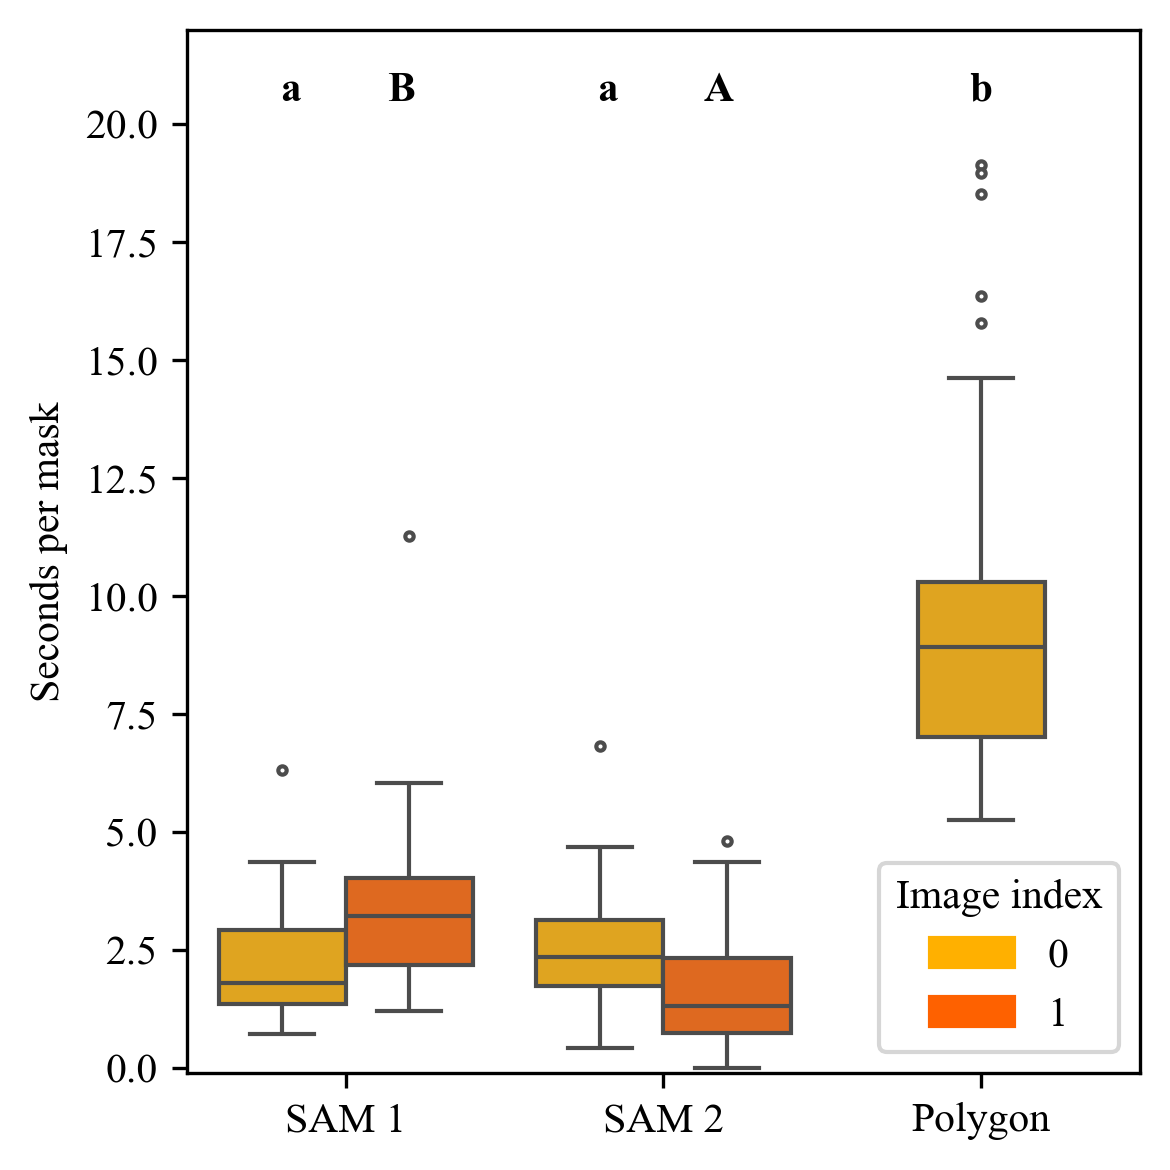

In [212]:
df_s_per_mask = df_sample.copy()
df_s_per_mask["s_per_mask"] = df_s_per_mask["ds_per_mask"] / 10
df_s_per_mask["first_img"] = df_s_per_mask["first_img"].astype(int).replace({1: 0, 0: 1})
df_s_per_mask["method"] = df_s_per_mask["method"].replace({"sam1": "SAM 1", "sam2": "SAM 2", "polygon": "Polygon"})

get_s_per_mask_boxplot(df_s_per_mask.loc[df_s_per_mask["method"]!="Polygon"], df_s_per_mask.loc[df_s_per_mask["method"]=="Polygon"], xkey="method", ykey="s_per_mask", colour_key="first_img")


## Overlapping user masks

In [265]:
def normalize_array_numpy(X, ignore_below, ignore_above):
    """
    Normalize a NumPy array to a specified range [0, 255], ignoring values below and above specified thresholds.

    Parameters:
    - X (np.ndarray): Input array to normalize.
    - ignore_below (float): Values below this threshold will be set to 0.
    - ignore_above (float): Values above this threshold will be set to 255.

    Returns:
    - np.ndarray: Normalized array.
    """
    
    
    #X = np.where(X < ignore_below, ignore_below, X)
    #X = np.where(X > ignore_above, ignore_above, X)

    X_min = np.min(X) 
    X_max = np.max(X) 

    
    # Apply the normalization formula
    X_normalized = (X - X_min) / (X_max - X_min)  # Scale to [0, 1]
    
    X_normalized = X_normalized * 255  # Scale to [0, 255]

    return X_normalized.astype(np.uint8)

def read_and_match_masks(img_df:pd.DataFrame):
    mask_paths = img_df["path"].unique()

    return sum([cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE) > 0 for mask_p in mask_paths])
       
def project_heat_maps(images, heatmaps, max_val, img_ids, vmin=2):
    # Create a figure with 6 subplots in 2 rows x 3 columns (adjust as desired)
    fig, axs = plt.subplots(1, 6, figsize=(12, 6))  # adjust figsize as needed

    # Flatten axs for easy iteration (so we can do axs[i] in a 1D manner).
    #axs = axs.ravel()
    # OPTIONAL: set a global max for the color normalization
    # ignoring zeros, find maximum across all heatmaps
   

    norm = mcolors.Normalize(vmin=vmin, vmax=max_val)  # or vmin=0 if you want 0 in range


    for i, (img, hm) in enumerate(zip(images, heatmaps)):
        # Show the RGB image
        axs[i].imshow(img)
        img_id = img_ids[i]
        
        # Overlay the heatmap
        # By default, imshow will normalize int32 -> float [vmin, vmax],
        # so you can just display it directly. 
        # Adjust 'alpha' for transparency and choose a colormap (e.g., 'jet', 'magma', 'viridis', etc.)
        hm_masked = np.ma.masked_where(hm < vmin, hm)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        norm_array = normalize_array_numpy(hm_masked.data, vmin, max_val)
        overlay0 = cv2.addWeighted(img_bgr, 1, cv2.applyColorMap(norm_array, cv2.COLORMAP_COOL), 0.9, 0)
        mask = hm_masked.mask.astype(np.uint8)*255
        neg_mask = cv2.bitwise_not(mask)
        overlay_roi = cv2.bitwise_and(cv2.applyColorMap(norm_array, cv2.COLORMAP_COOL), cv2.applyColorMap(norm_array, cv2.COLORMAP_COOL), mask=neg_mask)
        img_roi = cv2.bitwise_and(img_bgr, img_bgr, mask=hm_masked.mask.astype(np.uint8))
        overlay = cv2.add(overlay_roi, img_roi)
        
        
       
        cv2.imwrite(f"{img_id}_overlay.png", overlay)
        im = axs[i].imshow(hm_masked, cmap='cool', alpha=0.9, norm=norm)
        
        
        # Turn off axes for a cleaner look
        axs[i].axis('off')
    plt.tight_layout()
    # Add a single colorbar (which acts as a legend for heatmap values)
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
    
def create_custom_colorbar(cmap_name='cool', vmin=0, vmax=100, 
                          orientation='horizontal', 
                          ticks=None, ticklabels=None, 
                          filename='colorbar.png', 
                          figsize=(6, 1), dpi=300):
   
    fig, ax = plt.subplots(figsize=figsize)
    if orientation == 'horizontal':
        fig.subplots_adjust(bottom=0.4, top=0.5, left=0.05, right=0.95)
    else:
        fig.subplots_adjust(left=0.5, right=0.5, bottom=0.05, top=0.95)

    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    cb = ColorbarBase(ax, cmap=cmap, norm=norm, orientation=orientation)

    if ticks is not None:
        cb.set_ticks(ticks)
    if ticklabels is not None:
        cb.set_ticklabels(ticklabels)
    
    #plt.savefig(filename, dpi=dpi, bbox_inches='tight')


39320223493024_low_192
39320223493024_low_256
39320223525022_low_2688
39320223525022_low_2752
39420224413028_low_1856
39420224413028_low_1920


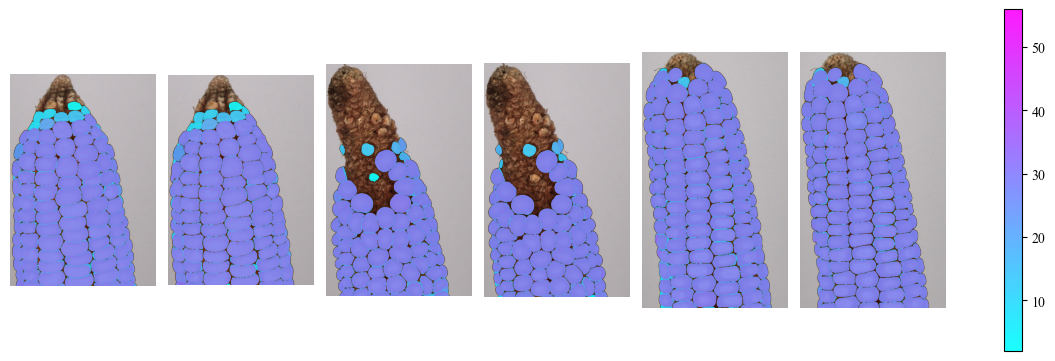

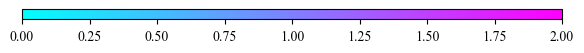

In [266]:

df_sammask = df_mask.loc[df_mask["method"] != "polygon"].copy()
df_sammask["img_id"] = df_sammask.loc[:,"ear_id"] + "_low_" + df_sammask.loc[:,"ear_view_pos"]
img_ids = df_sammask["img_id"].unique()
max_val_theory = len(df_sammask["user_id"].unique()) * len(df_sammask["method"].unique())
max_val = max_val_theory
imgs = []
hms = []
for img_id in img_ids:
    print(img_id)
    heatmap_dest = f"{img_id}_kernel_heatmap.npy"
    img_p = rf"C:\Users\geink81\Desktop\ARAMSAM_UserExperiment\User_0\{img_id}_annots_structured_sam1\img.jpg"
    img = cv2.imread(img_p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not os.path.exists(heatmap_dest):
        df_img = df_sammask.loc[df_sammask["img_id"] == img_id]
        heat_map = read_and_match_masks(df_img)
        np.save(heatmap_dest, heat_map)
    else:
        heat_map = np.load(heatmap_dest)
    if np.max(heat_map) > max_val:
        max_val = np.max(heat_map)
    imgs.append(img)
    hms.append(heat_map)

project_heat_maps(imgs, hms, max_val, img_ids)

cbar_max = max_val / max_val_theory

create_custom_colorbar(vmin=0, vmax=cbar_max, filename='colorbar.png')
